In [2]:
'''
Calculate signal_cc, ignore RFs, for blobs data (CORRS).
Also calculate pairwise pearsons correlation between size-matched tuning curves.
Note: Unlike DISTS, pw correlations here restrict comparisons to common best_size.

Save figures for main.
'''

'\nCalculate signal_cc, ignore RFs, for blobs data (CORRS).\nAlso calculate pairwise pearsons correlation between size-matched tuning curves.\nNote: Unlike DISTS, pw correlations here restrict comparisons to common best_size.\n\nSave figures for main.\n'

In [1]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib

import analyze2p.objects.selectivity as sel
import analyze2p.objects.sim_utils as su

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(axis_labelsize=7, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

new_root = '/n/holylfs05/LABS/pfister_lab/Lab'
aggregate_dir = aggregate_dir.replace('/n', new_root)
rootdir = rootdir.replace('/n', new_root)

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [3]:
experiment = 'blobs'
responsive_test='ROC'
trial_epoch = 'stimulus'
# ---------------------------------------------------------------
response_type='dff'
if experiment=='rfs' and responsive_test=='nstds':
    responsive_thr=7.0
else:
    responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)

ROC 0.05


In [4]:
response_type='dff'
do_spherical_correction=False
combine_rfs='average'
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
print(rf_str)

rfs-dff-uncorr


# Load data

In [5]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, 
                            return_cells=True, create_new=False)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [6]:
# Load trial metrics
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1259 |
| Lm |          1048 |
| Li |           583 |
|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            16 |
| V1 |            16 |


In [7]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA0['datakey'].unique(), 
                            experiment=experiment,
                            images_only=False, rename=experiment=='blobs',
                            return_incorrect=True, return_all=False)
incorrect_stim.keys()

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])

In [8]:
min_ncells=5
match_all_stimuli = False
# -------------------------------------------
counts0 = aggr.count_n_cells(CELLS, name='n_cells', reset_index=True)
# Get unique dkeys based on # cells fit
if match_all_stimuli:
    counts = counts0[(counts0.datakey.isin(SDF['datakey'].unique()))
                   & (counts0.n_cells>=min_ncells)]
else:
    counts = counts0[(counts0.n_cells>=min_ncells)]
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells') 

if match_all_stimuli:
    NDATA = pd.concat([g for (va, dk), g \
                       in NDATA0.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in u_dkeys and dk in SDF['datakey'].unique()], 
                      ignore_index=True)
else:
    NDATA = pd.concat([g for (va, dk), g \
                       in NDATA0.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in u_dkeys], 
                      ignore_index=True)
    
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       579 |
| Lm            |      1047 |
| V1            |      1257 |
[V1] Animalid does not exist: JC078 
FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       375 |        10 |
| Lm            |       653 |         9 |
| V1            |      1031 |         9 |


In [9]:
NDATA[NDATA['visual_area']=='Li'].groupby('datakey')['cell'].nunique()

datakey
20190315_JC070_fov1    22
20190316_JC070_fov1     7
20190322_JC073_fov1    38
20190422_JC076_fov1    29
20190602_JC091_fov1    87
20190606_JC091_fov1    48
20190609_JC099_fov1    60
20190617_JC099_fov1     7
20191018_JC113_fov1    47
20191111_JC120_fov1    30
Name: cell, dtype: int64

In [10]:
NDATA[['visual_area', 'datakey']].drop_duplicates().groupby('visual_area').count()

datakey
visual_area         
Li                10
Lm                 9
V1                 9

## Get RFs

In [11]:
# ------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine=combine_rfs, 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position',
                              rootdir=rootdir)
rfdf = aggr.add_roi_positions(rfdf, rootdir=rootdir)

# Get polygons
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc, combine_method=combine_rfs,
                                 aggregate_dir=aggregate_dir)
except FileNotFoundError as e:
    print("Creating new RF polys...")
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, 
                                    combine_method=combine_rfs,
                                    create_new=True,
                                    aggregate_dir=aggregate_dir)

N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4


In [12]:
# r_list = []
# p_list = []
# for (va, dk), df_ in NDATA0.groupby(['visual_area', 'datakey']):
#     rf_ = rfdf[(rfdf['visual_area']==va) & (rfdf['datakey']==dk)
#             & (rfdf['cell'].isin(df_['cell'].values))]
#     poly_ = rfpolys[ (rfpolys['datakey']==dk)
#             & (rfpolys['cell'].isin(rf_['cell'].values))]
#     r_list.append(rf_)
#     p_list.append(poly_)

# rfdf_filt = pd.concat(r_list)
# rfpolys_filt = pd.concat(p_list)
# rfdf_filt.shape, rfdf.shape

In [13]:
# rfpolys.shape, rfdf.shape, rfdf_filt.shape

In [14]:
# rfpolys.shape, rfpolys_filt.shape

# Output dirs

In [15]:
responsive_str = '%s_%s_%s-%.2f' % (trial_epoch, response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)

#### Set current output dir
base_dir = os.path.join(aggregate_dir, 'correlations', 
                       'blobs_%s_%s' % (response_type, responsive_test),
                       'morph_tuning')
print(base_dir)
print(base_dir)
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'correlate_tuning_curves_MIGR')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)
print(FIGDIR)

traces001|stimulus_dff_ROC-0.05|rfs-dff-uncorr
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR


# Aggregate

In [16]:
import _pickle as pkl
import copy 

In [17]:
offset_type='minsub' 
lcorrection='none' # TODO
with_lum = False
lum_str = 'allstim' if with_lum else 'imagesonly' 
create_new=False
# ----------------------------------------
# Results outfile - same suffix as folder 
blob_str = '%s_%s_%s-%s_%s' % (trial_epoch, responsive_test, offset_type, lcorrection, lum_str)
dists_results_file = os.path.join(base_dir, 'results_%s_%s.pkl' % (blob_str, rf_str))
print(dists_results_file)
try: 
    assert os.path.exists(dists_results_file), "Results file does not exist"
except AssertionError as e:
    print(e)
    create_new=True
# Figure save dir
dst_dir = os.path.join(base_dir, '%s_%s' % (blob_str, rf_str))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_stimulus_ROC_minsub-none_imagesonly_rfs-dff-uncorr.pkl
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/stimulus_ROC_minsub-none_imagesonly_rfs-dff-uncorr


In [18]:
dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/stimulus_ROC_minsub-none_imagesonly_rfs-dff-uncorr'

In [19]:
create_new=False

In [20]:
# create_new=False
if not create_new:
    try:
        with open(dists_results_file, 'rb') as f:
            res = pkl.load(f)
        DISTS = res['DISTS']
        avg_responses = res['responses']
        rfdf = res['rfdf']
        CORRS = res['CORRS']
        #del res
    except Exception as e:
        create_new=True
print("new? %s" % str(create_new))

new? False


In [133]:
#     with open(dists_results_file, 'rb') as f:
#         res = pkl.load(f)

In [21]:
res.keys()

dict_keys(['rfdf', 'DISTS', 'NDATA', 'responses', 'CORRS'])

In [34]:
# res['DSTS_rfs'] = res['DISTS'].copy()

In [37]:
# Calculate distances
# with_lum=False
create_new=False
if create_new:
    print("Getting average responses to each stimulus: {}".format(lum_str))
    rdf_list=[]
    for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):

        sdf = aggr.get_stimuli(dk, experiment, match_names=True)
        if with_lum:
            configs = sdf.index.tolist()
        else:
            configs = sdf[sdf['morphlevel']!=-1].index.tolist()
        sizes = list(sorted(sdf['size'].unique()))
        morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
        
        # Exclude lum, if relevant
        tmp_cfgs = sdf.index.tolist() if lcorrection!='none' else configs
        x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
                  & (NDATA0.config.isin(tmp_cfgs))].copy()
        rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config'])\
                 .mean().reset_index().drop('trial', axis=1)
        rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
        rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
        if lcorrection=='exclude':
            print('    %s, %s: excl. %i of %i' \
                  % (va, dk, len(rdf['cell'].unique()),
                     len(rdf_offset['cell'].unique())))

        rdf['size'] = sdf.loc[rdf['config']]['size'].values
        rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
        rdf_list.append(rdf[rdf.config.isin(configs)])
    avg_responses = pd.concat(rdf_list, axis=0, ignore_index=True)
    avg_responses['experiment'] = 'blobs'

Getting average responses to each stimulus: imagesonly


In [18]:
create_new

False

### CORRS:  signal_cc and noise_cc

In [126]:
if create_new:
    if experiment=='blobs':
        select_stimuli='images'
    else:
        select_stimuli='all'
        
    use_sdf = SDF.copy() if match_all_stimuli else None
    distance_var = 'rf_distance'
    min_ncells=5
    normalize_tuning_curves=True
    
    if with_lum==False:
        tuning_curve_data = avg_responses[avg_responses.morphlevel!=-1].copy()
    else:
        tuning_curve_data = avg_responses.copy()
        
    DISTS = cr.aggregate_tuning_curve_ccdist(tuning_curve_data, 
                    #rfdf=rfdf_filt, rfpolys=rfpolys_filt, 
                    sort_best_size=False, normalize=normalize_tuning_curves,
                    min_ncells=min_ncells, stimulus=experiment)

    CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, #rfdf=rfdf, rfpolys=rfpolys,
                SDF=None, select_stimuli=select_stimuli,min_ncells=min_ncells,
                match_stimulus_names=match_all_stimuli,
                verbose=True, rootdir=rootdir)

    (20190315_JC070_fov1 NONE, skipping overlaps)
    (20190322_JC073_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20190322_JC073_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
[]
Dist: cortical_distance
Li 20190315_JC070_fov1 blobs
Li 20190322_JC073_fov1 blobs
Li 20190422_JC076_fov1 blobs
Li 20190602_JC091_fov1 blobs
Li 20190609_JC099_fov1 blobs
Li 20190614_JC091_fov1 blobs
Li 20191018_JC113_fov1 blobs
Li 20191111_JC120_fov1 blobs
Lm 20190322_JC073_fov1 blobs
Lm 20190422_JC076_fov1 blobs
Lm 20190430_JC078_fov1 blobs
Lm 20190504_JC078_fov1 blobs
Lm 20190506_JC080_fov1 blobs
Lm 20190508_JC083_fov1 blobs
Lm 20190525_JC084_fov1 blobs
Lm 20190618_JC097_fov1 blobs
Lm 20190627_JC091_fov1 blobs
V1 20190501_JC076_fov1 blobs
V1 20190507_JC083_fov1 blobs
V1 20190512_JC083_fov1 blobs
V1 20190522_JC084_fov1 blobs
V1 20190613_JC097_fov1 blobs
V1 20190616_JC097_fov1 blobs
V1 20190617_JC097_fov1 blobs
V1 20190622_JC085_fov1 blob

In [22]:
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('visual_area').count()

datakey  cell
visual_area               
Li               375   375
Lm               653   653
V1              1031  1031

In [ ]:
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('datakey').count()

In [23]:
print(match_all_stimuli)
select_stimuli = 'images'

False


In [24]:
# normalize_tuning_curves=True
# tuning_curve_data = avg_responses[avg_responses.morphlevel!=-1].copy()
# DISTS = cr.aggregate_tuning_curve_ccdist(tuning_curve_data, 
#                 rfdf=None, rfpolys=None, 
#                 sort_best_size=False, normalize=normalize_tuning_curves,
#                 min_ncells=min_ncells, stimulus=experiment)

In [25]:
# CORRS.shape, DISTS.shape

In [25]:
# incl_cc_cols = ['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
#                'visual_area', 'datakey']
# cols_to_add = [c for c in CORRS.columns if c not in DISTS.columns]
# cols_to_add.extend(['visual_area', 'datakey', 'neuron_pair', 'cell_1', 'cell_2'])
# ccdist = pd.merge(CORRS, DISTS,
#             on= [c for c in CORRS.columns if c in DISTS.columns], 
#             how='outer', suffixes=('_fit', '_responsive'))
# ccdist.shape, DISTS.shape, CORRS.shape

#### Save

In [131]:
print(dists_results_file)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_stimulus_ROC_minsub-none_imagesonly_rfs-dff-uncorr.pkl


In [26]:
DISTS.shape, CORRS.shape

((115777, 25), (115777, 10))

In [133]:
if create_new:
#     with open(dists_results_file, 'wb') as f:
#         res = pkl.load(f)
    res = {'rfdf': rfdf, 'DISTS': DISTS, 'NDATA': NDATA,
           'responses': avg_responses, 'CORRS': CORRS}
    with open(dists_results_file, 'wb') as f:
        pkl.dump(res, f, protocol=2)

In [27]:
CORRS[CORRS['visual_area']=='Li']['datakey'].nunique()

8

In [28]:
select_stimuli

'images'

In [28]:
# CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, #rfdf=rfdf, rfpolys=rfpolys,
#                     SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
#                     verbose=True, rootdir=rootdir)
# # Save
# with open(dists_results_file, 'rb') as f:
#     res = pkl.load(f)
# res = {'rfdf': rfdf, 'DISTS': DISTS, 'NDATA': NDATA,
#        'responses': avg_responses, 'CORRS': CORRS}
# with open(dists_results_file, 'wb') as f:
#     pkl.dump(res, f, protocol=2)

In [30]:
# with open(dists_results_file, 'rb') as f:
#     res = pkl.load(f)
# res = {'rfdf': rfdf, 'DISTS': DISTS, 'NDATA': NDATA,
#        'responses': avg_responses, 'CORRS': CORRS}
# with open(dists_results_file, 'wb') as f:
#     pkl.dump(res, f, protocol=2)

In [136]:
res.keys()

dict_keys(['rfdf', 'DISTS', 'NDATA', 'responses', 'CORRS'])

# Each FOV

In [29]:
%matplotlib notebook

In [30]:
import math
n = 5
r = 2
n_combos = math.comb(n, r)
print(n_combos)

10


In [31]:
# curr_corrs = CORRS[CORRS['visual_area']=='Li'].copy()
ctx_maxdist = 1000
ctx_mindist= 30
ctx_step=50
currcorrs = DISTS[(DISTS.cortical_distance<=ctx_maxdist)
                  & (DISTS.cortical_distance>ctx_mindist)
          ].copy().dropna()
# Cut bins
currcorrs, dist_lut = cr.get_bins_and_cut(currcorrs, ctx_step=ctx_step, rf_step=2.5, 
                                   dir_step=30, ori_step=15)

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


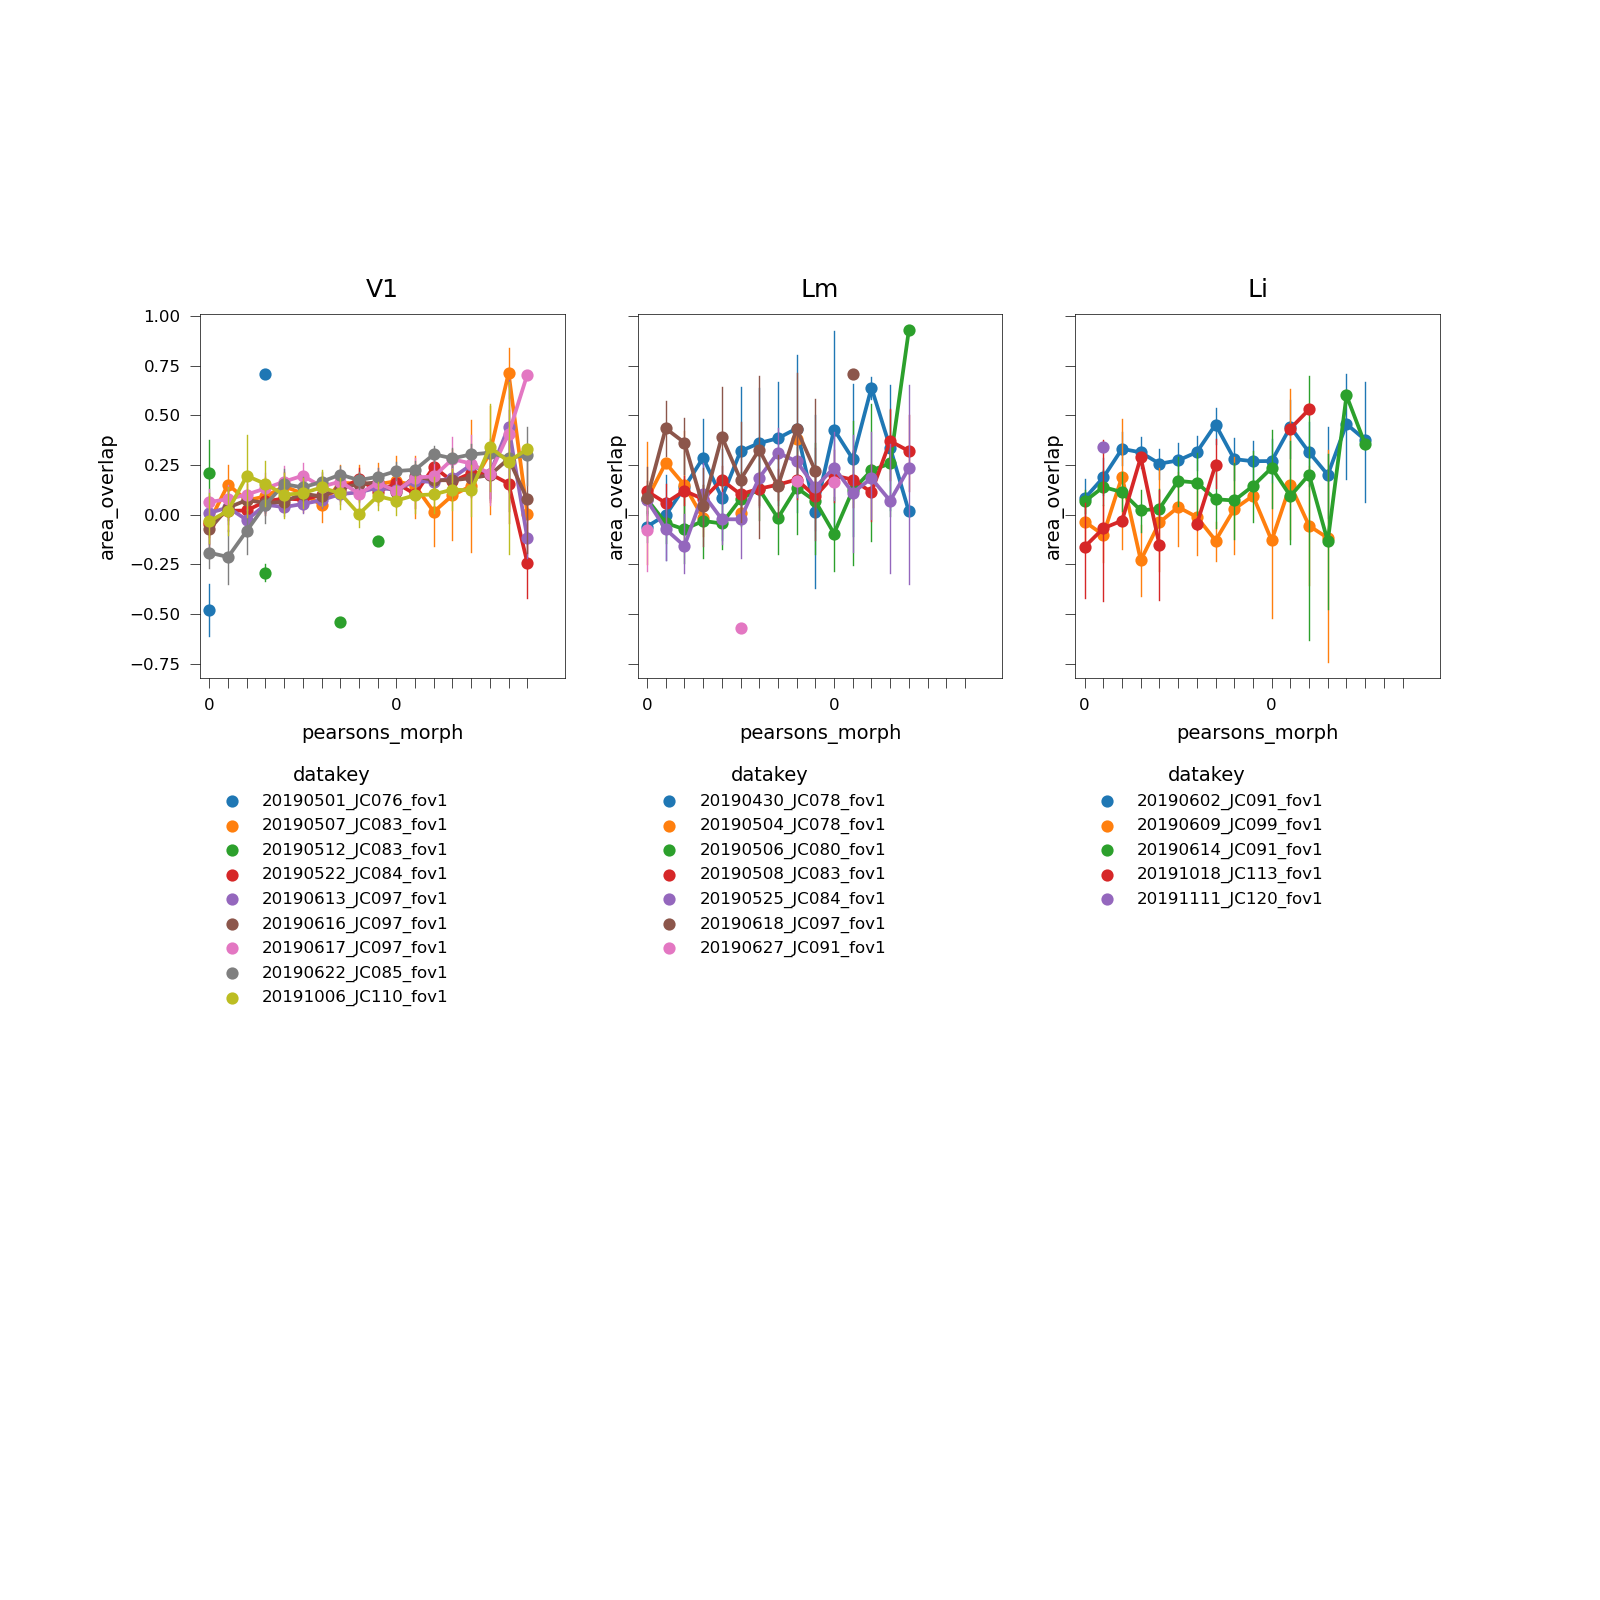

In [41]:
x_var = 'area_overlap'
y_var = 'pearsons_morph'

if x_var == 'area_overlap':
    xlabel = 'RF overlap (%)'
else:
    xlabel = 'RF distance (deg.)' if x_var == 'rf_distance'\
            else 'Cortical distance (\u00b5m)'

# Find the max. bin number where neuron_pair is non-zero
counts_per_bin = currcorrs.groupby(['visual_area', 'datakey', 'binned_{}'.format(x_var)])\
                        ['neuron_pair'].count().reset_index()

populated_bins = counts_per_bin[counts_per_bin['neuron_pair']>n_combos]
max_populated_bin = populated_bins.groupby('visual_area')['binned_{}'.format(x_var)].max()

fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(8, 8))
ax=axn[0]
for va, vg in currcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    max_bin = max_populated_bin.loc[va]
    incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=incl_vg, ax=ax, errorbar=('ci', 95),
                scale=0.5, errwidth=0.5)
    sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
    ax.set_box_aspect(1) #.75)
    ax.set_title(va)
    ax.set_xlabel(y_var) #'Cortical distance (um)')
    ax.set_ylabel(x_var)

    xlabels = sorted(incl_vg['binned_{}'.format(x_var)].unique())
    ax.set_xticks(range(len(xlabels)))
    ax.set_xlim([-0.5, np.argmax(xlabels) +2])
    xticks = ax.get_xticks()
    xtick_labels = [int(xlabels[i]) if i%10==0 else "" for i, x in enumerate(xticks)]
    ax.set_xticklabels(xtick_labels)
pl.subplots_adjust(bottom=0.5)

# # figname = 'each_FOV_{}_vs_{}_fovs'.format(x_var, y_var)
# # pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# # pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [33]:
DISTS.columns

Index(['xcorr_morph', 'pearsons_morph', 'cosim_morph', 'cell_1', 'cell_2',
       'neuron_pair', 'xcorr_size', 'pearsons_size', 'cosim_size',
       'max_response', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance', 'rf_angle_diff', 'rf_angle_diff_abs', 'std_x',
       'std_y', 'aspect_ratio', 'area_overlap', 'perc_overlap',
       'overlap_index', 'visual_area', 'datakey', 'n_cells'],
      dtype='object')

##### plot it prettier

In [34]:
mono_cdict = dict((k, [0.5]*3) for k in currcorrs['datakey'].unique())

In [36]:
%matplotlib notebook

<IPython.core.display.Javascript object>


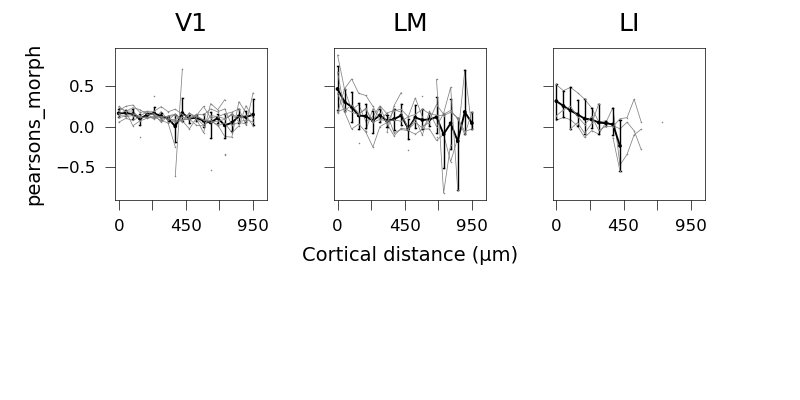

In [42]:
x_var = 'cortical_distance'
y_var = 'pearsons_morph'

# mean
corr_means = currcorrs.dropna().groupby(['visual_area', 'datakey', \
                                 'binned_{}'.format(x_var)]).mean().reset_index()
n_dks_per_bin = corr_means.groupby(['visual_area', 'binned_{}'.format(x_var)]).count().reset_index()
max_bin_va = n_dks_per_bin[n_dks_per_bin[x_var]>=4]\
                .groupby('visual_area')['binned_{}'.format(x_var)].max()

if x_var == 'area_overlap':
    xlabel = 'RF overlap (%)'
else:
    xlabel = 'RF distance (deg.)' if x_var == 'rf_distance'\
            else 'Cortical distance (\u00b5m)'

# Find the max. bin number where neuron_pair is non-zero
counts_per_bin = currcorrs.groupby(['visual_area', 'datakey', 'binned_{}'.format(x_var)])\
                        ['neuron_pair'].count().reset_index()

populated_bins = counts_per_bin[counts_per_bin['neuron_pair']>n_combos]
max_populated_bin = populated_bins.groupby('visual_area')['binned_{}'.format(x_var)].max()

#curr_plotdf = currcorrs[currcorrs['visual_area']=='Li'].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(4, 2)) #2, 1))

ax=axn[0]
for va, vg in currcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    #max_bin = max_populated_bin.loc[va]
    #incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax, errorbar=None, palette=mono_cdict,
                scale=0.1, errwidth=0.5, markers='.')
    ax.legend_.remove() #sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
    ax.set_box_aspect(1)
    ax.set_title(va)
    ax.set_xlabel('Cortical distance (um)')
    ax.set_ylabel('Signal CC')
    
#     xlabels = sorted(incl_vg['binned_{}'.format(x_var)].unique())
#     ax.set_xticks(range(len(xlabels)))
#     ax.set_xlim([-0.5, np.argmax(xlabels) +2])

# #x_bins = sorted(curr_plotdf['%s_label' % x_var].unique())
# for va, vg in currcorrs.groupby('visual_area'):
#     ax=axn[visual_areas.index(va)]
#     sns.pointplot(x='binned_%s' % x_var, y=y_var, 
#             data=vg, ax=ax, errorbar='se',
#             color='k',scale=0.3, errwidth=0.5)
# Plot MEAN
# dk_means = currcorrs.groupby(['visual_area', 'datakey', \
#                                  'binned_{}'.format(x_var)]).mean().reset_index()
for va, vg in corr_means.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    max_bin = max_populated_bin.loc[va]
    incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin] #_va.loc[va]]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, 
            data=incl_vg, ax=ax, #errorbar='se',
            color='k', markers='.', scale=0.25, errwidth=0.5, capsize=0.15)
    ax.set_zorder(5000)  # Adjust the value as needed
    ax.set_box_aspect(1)
    ax.set_ylabel('{}'.format(y_var)) if va=='V1' else ax.set_ylabel('')
    ax.set_xlabel(xlabel) if va=='Lm' else ax.set_xlabel('')
    
    xlabels = sorted(incl_vg['binned_{}'.format(x_var)].unique())
    ax.set_xlim([-0.5, len(xlabels)+1 ])
    xticks = np.linspace(0, len(xlabels)-1, 5)
    xtick_labels = [int(xlabels[int(x)]) if i%2==0 or i==len(xticks)-1 
                else "" for i, x in enumerate(xticks)]
    ax.set_xticks( xticks )
    ax.set_xticklabels(xtick_labels)
    ax.set_title(va.upper())
    
pl.subplots_adjust(bottom=0.5)

figname = 'each_FOV_{}_vs_{}_ctxmaxdist-{}um_{}_mono'.format(
                x_var, y_var, ctx_maxdist, trial_epoch)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [43]:
from itertools import combinations
import statsmodels.stats.multitest as smm

In [44]:
# x_var = 'cortical_distance'
# y_var = 'signal_cc'
s_list = []
i=0
for va, vg in currcorrs.groupby('visual_area'):
    for d, d_vg in vg.groupby('datakey'):
        X = d_vg[x_var].values
        y = d_vg[y_var].values
        slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
        if np.isnan(p_value):
            continue
        # print('{}: r={:.2f}, p={:.2f}'.format(d, r_value, p_value))
        stat = pd.DataFrame({'visual_area': va, 'datakey': d,
                      'slope': slope,
                      'intercept': intercept,
                      'pearson_r': r_value,
                      'p_value': p_value,
                      'std_err': std_err}, index=[i])
        s_list.append(stat)
        i+=1
statdf = pd.concat(s_list)

In [45]:
statdf

visual_area              datakey     slope  intercept  pearson_r  \
0           Li  20190602_JC091_fov1 -0.001465   0.631915  -0.339146   
1           Li  20190609_JC099_fov1 -0.000143   0.009412  -0.062915   
2           Li  20190614_JC091_fov1 -0.000559   0.223381  -0.164970   
3           Li  20191018_JC113_fov1 -0.001193   0.287759  -0.369989   
4           Lm  20190430_JC078_fov1 -0.000598   0.316625  -0.284888   
5           Lm  20190504_JC078_fov1  0.000235   0.020851   0.163723   
6           Lm  20190506_JC080_fov1  0.000139  -0.005028   0.056354   
7           Lm  20190508_JC083_fov1 -0.000065   0.162599  -0.037760   
8           Lm  20190525_JC084_fov1 -0.000275   0.202631  -0.123532   
9           Lm  20190618_JC097_fov1 -0.000705   0.478683  -0.292740   
10          Lm  20190627_JC091_fov1  0.000166  -0.146311   0.127759   
11          V1  20190501_JC076_fov1 -0.001082   0.516926  -0.278840   
12          V1  20190507_JC083_fov1 -0.000263   0.205399  -0.100229   
13          V1  20190512_JC083_fov1 -0.000907   0.270249  -0.668377   
14          V1  20190522_JC084_fov1 -0.000170   0.176683  -0.072188   
15          V1  20190613_JC097_fov1 -0.000029   0.107676  -0.014445   
16          V1  20190616_JC097_fov1 -0.000046   0.133632  -0.021674   
17          V1  20190617_JC097_fov1 -0.000103   0.184445  -0.042511   
18          V1  20190622_JC085_fov1 -0.000146   0.242800  -0.057109   
19          V1  20191006_JC110_fov1  0.000022   0.087709   0.009329   

         p_value   std_err  
0   1.411168e-33  0.000118  
1   4.537718e-01  0.000191  
2   2.596807e-04  0.000152  
3   5.748746e-02  0.000599  
4   1.194286e-05  0.000134  
5   6.513035e-01  0.000501  
6   2.292247e-01  0.000115  
7   1.842652e-01  0.000049  
8   1.099318e-02  0.000108  
9   2.441762e-03  0.000227  
10  8.094035e-01  0.000645  
11  8.201004e-01  0.003727  
12  7.864700e-04  0.000078  
13  1.467256e-01  0.000504  
14  1.838626e-04  0.000045  
15  4.109460e-01  0.000035  
16  1.412361e-01  0.000031  
17  6.621814e-02  0.000056  
18  6.141222e-04  0.000043  
19  7.764359e-01  0.000078

In [46]:
stat_var = 'slope'
#perform Kolmogorov-Smirnov test
results = {}
groups = ['V1', 'Lm', 'Li']
k_ = []
for group1, group2 in combinations(groups, 2):
    ks_stat, p_value = spstats.mannwhitneyu(
                statdf[statdf['visual_area']==group1][stat_var], 
                statdf[statdf['visual_area']==group2][stat_var],
                alternative='greater')
    results[f"{group1} vs {group2}"] = (ks_stat, p_value)

# Apply Bonferroni correction
adjusted_p_values = smm.multipletests([r[1] for r in 
                                       results.values()], method='fdr_bh')[1]
# Print results
for (comparison, (ks_stat, p)), adj_p in zip(results.items(), adjusted_p_values):
    print(f"{comparison}: KS-stat = {ks_stat:.2f}, p = {p:.2f}, adjusted p = {adj_p:.2e}")
    ks = pd.DataFrame({'comparison': comparison,
                 'ks_stat': ks_stat,
                 'p': p,
                 'adjusted_p': adj_p}, index=[i])
    i+=1
    k_.append(ks)
sigdf = pd.concat(k_).reset_index(drop=True)
sigdf['A'] = [c.split(' ')[0] for c in sigdf['comparison']]
sigdf['B'] = [c.split(' ')[-1] for c in sigdf['comparison']]
sigdf

V1 vs Lm: KS-stat = 24.00, p = 0.80, adjusted p = 7.96e-01
V1 vs Li: KS-stat = 29.00, p = 0.05, adjusted p = 8.18e-02
Lm vs Li: KS-stat = 23.00, p = 0.05, adjusted p = 8.18e-02


comparison  ks_stat         p  adjusted_p   A   B
0   V1 vs Lm     24.0  0.796066    0.796066  V1  Lm
1   V1 vs Li     29.0  0.053147    0.081818  V1  Li
2   Lm vs Li     23.0  0.054545    0.081818  Lm  Li

<IPython.core.display.Javascript object>


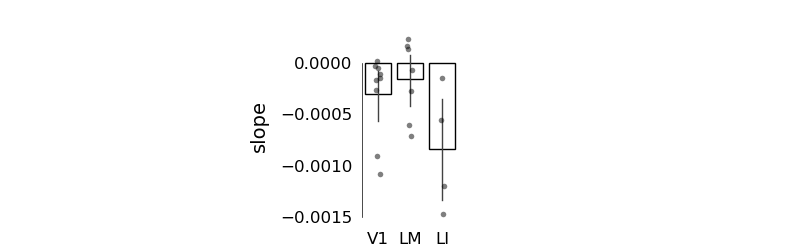

In [47]:
fig, ax = pl.subplots( figsize=(4,1.25))
for ai, yv in enumerate(['slope']): #, 'pearson_r']):
    ax=ax#n[ai]
    sns.barplot(statdf, x='visual_area', y=yv,ax=ax,
                  order=visual_areas, edgecolor='k', facecolor='none',
                errwidth=0.5, linewidth=0.5)
    sns.stripplot(statdf, x='visual_area', y=yv,ax=ax,
                  order=visual_areas, color='k', s=2,# hue='p_color', palette=p_cdict, size=3,
                  alpha=0.5)
    ax.set_box_aspect(2)
    pplot.annotate_multicomp_by_area(ax, sigdf,p_var='adjusted_p',
                                     offset=0.0002)
#     sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), 
#                     frameon=False, title='regr. fit', fontsize=6, markerscale=0.5)
    ax.tick_params(length=0)
#     ax.set_ylim([ -0.001, 0.0005])
    ax.set_xticklabels(['V1', 'LM', 'LI'])
    ax.set_xlabel('')

sns.despine(trim=True, bottom=True)

pl.subplots_adjust(right=0.9, wspace=0.5)

# figname = 'each_FOV_{}_vs_{}__ctxmax-{}um_stats'.format(x_var, y_var, ctx_maxdist)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
# print(figname)

In [117]:
sigdf

comparison  ks_stat         p  adjusted_p   A   B
0   V1 vs Lm     24.0  0.796066    0.796066  V1  Lm
1   V1 vs Li     29.0  0.053147    0.081818  V1  Li
2   Lm vs Li     23.0  0.054545    0.081818  Lm  Li

In [118]:
from itertools import combinations
import statsmodels.stats.multitest as smm

# Compare within best_size

In [48]:
NDATA.groupby(['visual_area', 'datakey'])['cell'].nunique()

visual_area  datakey            
Li           20190315_JC070_fov1     22
             20190316_JC070_fov1      7
             20190322_JC073_fov1     38
             20190422_JC076_fov1     29
             20190602_JC091_fov1     87
             20190606_JC091_fov1     48
             20190609_JC099_fov1     60
             20190617_JC099_fov1      7
             20191018_JC113_fov1     47
             20191111_JC120_fov1     30
Lm           20190322_JC073_fov1     25
             20190422_JC076_fov1     22
             20190430_JC078_fov1     98
             20190504_JC078_fov1     59
             20190506_JC080_fov1    145
             20190508_JC083_fov1    100
             20190525_JC084_fov1     91
             20190618_JC097_fov1     41
             20190627_JC091_fov1     72
V1           20190501_JC076_fov1     33
             20190507_JC083_fov1     97
             20190512_JC083_fov1     25
             20190522_JC084_fov1    107
             20190613_JC097_fov1    120
       

##### TEST 1 FOV

In [190]:
# all_morph_and_pos0[(all_morph_and_pos0['visual_area']=='Li')
#                   & (all_morph_and_pos0['datakey']=='20191018_JC113_fov1')]

In [115]:
va ='Li'
dk = '20191018_JC113_fov1'
# Select cells for this dataset
x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
          & (NDATA0.config.isin(configs))].copy()
sdf = aggr.get_stimuli(dk, experiment, match_names=True)
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))

# Get mean response to each config
rdf0 = x0.groupby(['cell', 'config', 'datakey', 'visual_area', 'experiment']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
# Get position of each cell
posdf = rdf[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
posdf = aggr.add_roi_positions(posdf, rootdir=rootdir)

#### Generate tuning curves
morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=False,
                                                normalize=True, return_stacked=True)

# morph_curves

In [116]:
df_list = []
for curr_size, curr_morph_curves in morph_curves.groupby('best_size'):
    curr_morph_curves = morph_curves[morph_curves['best_size']==curr_size]
    curr_rois = morph_curves[morph_curves['best_size']==curr_size]['cell'].unique()
    if len(curr_rois) < 3:
        continue
    # Stack current morph curves
    morph_mat = curr_morph_curves[['cell', 'response', 'morphlevel']]\
                        .pivot(columns='cell', index='morphlevel')
    morph_mat.columns = morph_mat.columns.droplevel()
    morph_mat = morph_mat.sort_index(ascending=True)

    # Current cell pairs
    col_pairs = list(itertools.combinations(curr_rois, 2))
    
    # Get pairwise corrs
    m_list = [cr.compare_curves(morph_mat[a].values, morph_mat[b].values, a=a, b=b) \
                                                        for (a, b) in col_pairs]
    curr_corrs = pd.concat(m_list, axis=1).T
    # df_morph
    morph_and_pos = cr.get_pw_distance(curr_corrs, posdf)
    morph_and_pos[['xcorr', 'pearsons', 'cosim']] = morph_and_pos[['xcorr', 'pearsons', 'cosim']].astype(float)
    # morph_and_pos.head()
    morph_and_pos['best_size'] = curr_size
    morph_and_pos['datakey'] = dk
    morph_and_pos['visual_area'] = va
    df_list.append(morph_and_pos)
all_morph_and_pos = pd.concat(df_list)

In [117]:
print(ctx_mindist)

currcorrs_ = all_morph_and_pos[all_morph_and_pos['cortical_distance']>=ctx_mindist].copy()


30


<IPython.core.display.Javascript object>


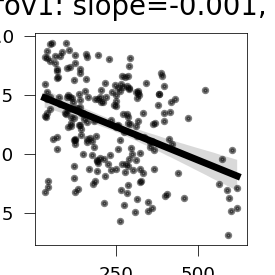

example_scatter_cortical_distance_vs_pearsons_ctxmax-1000um_Li-20191018_JC113_fov1


In [150]:
x_var = 'cortical_distance'
va = 'Li'
y_var='pearsons'
xlabel = 'RF distance (deg.)' if x_var == 'rf_distance'\
        else 'Cortical distance (\u00b5m)'

# stats
X = currcorrs_[x_var].values
y = currcorrs_[y_var].values
slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
stat_str = '{}: slope={:.3f}, r={:.3f}, p={:.3f}'.format(dk, slope, r_value, p_value)

# plot
fig, ax =pl.subplots(figsize=(1.25,1.25))
sns.regplot(data=currcorrs_, x=x_var, y=y_var, ax=ax,
            scatter_kws={'s': 2, 'alpha': 0.5}, color='k')
ax.set_box_aspect(1)
ax.set_title('Correlate within best_size\n{}'.format(stat_str))
ax.set_xlabel(xlabel)
ax.set_ylabel('Tuning similarity')

figname = 'example_scatter_{}_vs_{}_ctxmax-{}um_{}-{}'.format(x_var, y_var, \
                                                              ctx_maxdist, va, dk)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(figname)

In [ ]:
currcorrs_['cortical_distance'].min()

## Now, do all FOV

In [49]:
# dk = '20190622_JC085_fov1'
offset_type='minsub' 
lcorrection='none'
with_lum = False
normalize_tuning_curve = True

# Select cells for this dataset
# x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
#           & (NDATA0.config.isin(configs))].copy()
#df_list = []

df_list = []
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment, match_names=True)
    if with_lum:
        configs = sdf.index.tolist()
    else:
        configs = sdf[sdf['morphlevel']!=-1].index.tolist()
    sizes = list(sorted(sdf['size'].unique()))
    morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))

    # Get mean response to each config
    x0 = x0[(x0.config.isin(configs))].copy() # only get object stimuli
    rdf0 = x0.groupby(['cell', 'config', 'datakey', 'visual_area', 'experiment']).mean().reset_index().drop('trial', axis=1)
    rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
    rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
    rdf['size'] = sdf.loc[rdf['config']]['size'].values
    rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
    
    # Get position of each cell
    posdf = rdf[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
    posdf = aggr.add_roi_positions(posdf, rootdir=rootdir)

    #### Generate tuning curves
    morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=False,
                                normalize=normalize_tuning_curve, return_stacked=True)
    
    # For each best_size, do pairwise comparisons of morph tuning:
    #df_list = []
    for curr_size, curr_morph_curves in morph_curves.groupby('best_size'):
        curr_morph_curves = morph_curves[morph_curves['best_size']==curr_size]
        curr_rois = morph_curves[morph_curves['best_size']==curr_size]['cell'].unique()
        if len(curr_rois) < 3:
            continue
        # Stack current morph curves
        morph_mat = curr_morph_curves[['cell', 'response', 'morphlevel']]\
                            .pivot(columns='cell', index='morphlevel')
        morph_mat.columns = morph_mat.columns.droplevel()
        morph_mat = morph_mat.sort_index(ascending=True)

        # Current cell pairs
        col_pairs = list(itertools.combinations(curr_rois, 2))

        # Get pairwise corrs
        m_list = [cr.compare_curves(morph_mat[a].values, morph_mat[b].values, a=a, b=b) \
                                                            for (a, b) in col_pairs]
        curr_corrs = pd.concat(m_list, axis=1).T
        # Get pairwise correlations, ignore RFs
        morph_and_pos = cr.get_pw_distance(curr_corrs, posdf)
        morph_and_pos[['xcorr', 'pearsons', 'cosim']] = morph_and_pos[['xcorr', 'pearsons', 'cosim']].astype(float)
        # morph_and_pos.head()
        morph_and_pos['best_size'] = curr_size
        morph_and_pos['datakey'] = dk
        morph_and_pos['visual_area'] = va
        df_list.append(morph_and_pos)
    print(dk)
    #all_morph_and_pos0 = pd.concat(df_list)
    #v_list.append(all_morph_and_pos0)
all_morph_and_pos0 = pd.concat(df_list)

20190315_JC070_fov1
20190316_JC070_fov1
20190322_JC073_fov1
20190422_JC076_fov1
20190602_JC091_fov1
20190606_JC091_fov1
20190609_JC099_fov1
20190617_JC099_fov1
20191018_JC113_fov1
20191111_JC120_fov1
20190322_JC073_fov1
20190422_JC076_fov1
20190430_JC078_fov1
20190504_JC078_fov1
20190506_JC080_fov1
20190508_JC083_fov1
20190525_JC084_fov1
20190618_JC097_fov1
20190627_JC091_fov1
20190501_JC076_fov1
20190507_JC083_fov1
20190512_JC083_fov1
20190522_JC084_fov1
20190613_JC097_fov1
20190616_JC097_fov1
20190617_JC097_fov1
20190622_JC085_fov1
20191006_JC110_fov1


In [50]:
ctx_maxdist = 1000
ctx_mindist= 30
ctx_step = 50
# currcorrs = CORRS[(CORRS.cortical_distance<=ctx_maxdist)
#                   & (CORRS.cortical_distance>=ctx_mindist)
#           ].copy().dropna()
morph_pos_df = all_morph_and_pos0[(all_morph_and_pos0.cortical_distance<=ctx_maxdist)
                    & (all_morph_and_pos0.cortical_distance>ctx_mindist) ].copy().dropna()
# Cut bins
morph_pos_df, dist_lut = cr.get_bins_and_cut(morph_pos_df, ctx_step=ctx_step, 
                                    rf_step=2, 
                                   dir_step=30, ori_step=15)

In [51]:
morph_pos_df['cortical_distance'].max()

999.8530333661358

In [53]:
#### plot all

In [54]:
%matplotlib notebook

<IPython.core.display.Javascript object>


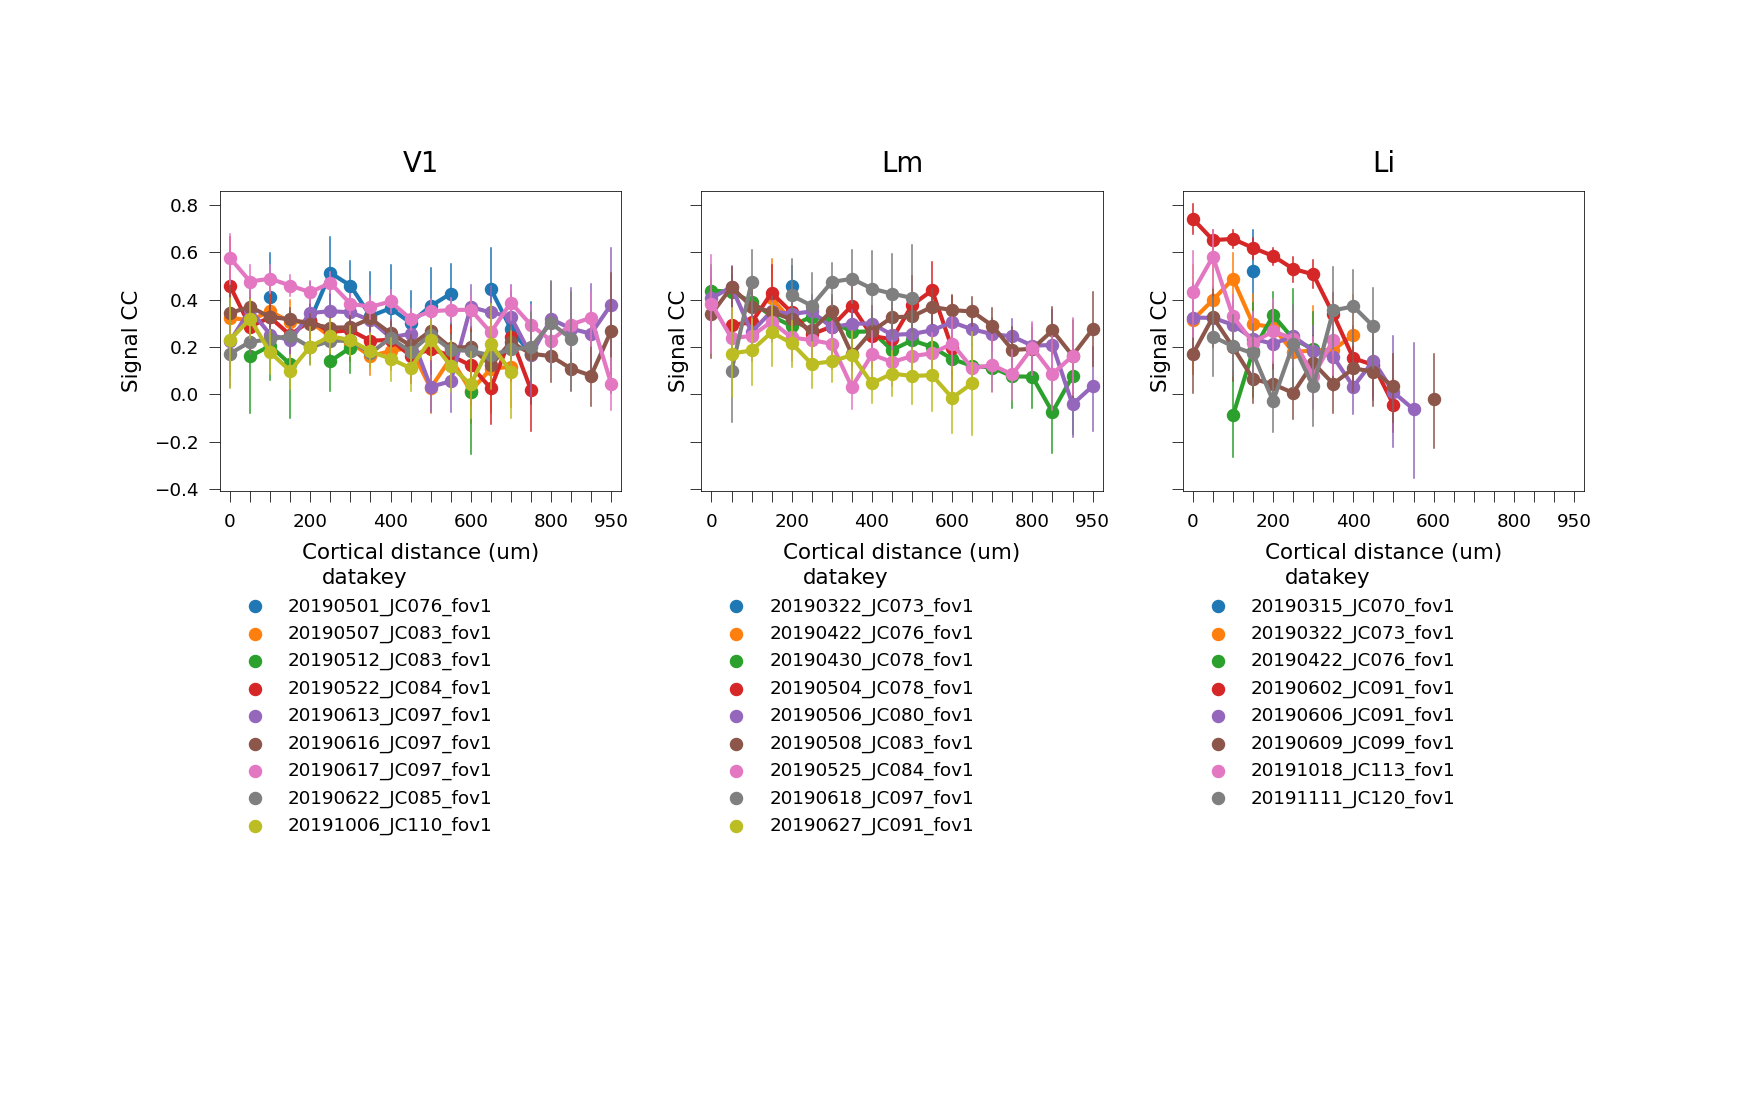

In [119]:
x_var = 'cortical_distance'
y_var = 'pearsons'

#curr_plotdf = currcorrs[currcorrs['visual_area']=='Li'].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(8, 5))
ax=axn[0]
for va, vg in filtered.groupby('visual_area'):

    ax=axn[visual_areas.index(va)]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax, errorbar=('ci', 95),
                scale=0.5, errwidth=0.5)
    sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
    ax.set_box_aspect(1) #0.75)
    ax.set_title(va)
    ax.set_xlabel('Cortical distance (um)')
    ax.set_ylabel('Signal CC')
pl.subplots_adjust(bottom=0.5)
xbins = sorted([i for i in dist_lut[x_var]['bins'] if i<=ctx_maxdist])
xticks = ax.get_xticks()
ax.set_xticklabels([int(xbins[i]) if i in xticks[0::4] or i==xticks[-1] \
                    else '' for i in xticks])

figname = 'each_FOV_{}_vs_{}_fovs'.format(x_var, y_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [108]:
mono_cdict = dict((k, [0.5]*3) for k in morph_pos_df['datakey'].unique())

In [109]:
morph_pos_df['cortical_distance'].min(), morph_pos_df['cortical_distance'].max()

(30.00672870288929, 999.8530333661358)

In [110]:
import math
n = 5
r = 2
n_combos = math.comb(n, r)
print(n_combos)

10


In [111]:
counts_per_bin = morph_pos_df.groupby(['visual_area', 'datakey', 'binned_{}'.format(x_var)])\
                        ['neuron_pair'].count().reset_index()
enough_nums = counts_per_bin[counts_per_bin['neuron_pair']>=n_combos]

In [129]:
filtered = pd.concat([morph_pos_df[(morph_pos_df['visual_area']==va)
                & (morph_pos_df['datakey']==dk)
                & (morph_pos_df['binned_cortical_distance']==bn)] \
            for (va, dk, bn), d_ in enough_nums\
            .groupby(['visual_area', 'datakey', 'binned_cortical_distance'])])

# mean
dk_means = filtered.groupby(['visual_area', 'datakey', \
                                 'binned_cortical_distance']).mean().reset_index()
n_dks_per_bin = dk_means.groupby(['visual_area', 'binned_cortical_distance']).count().reset_index()
max_bin_va = n_dks_per_bin[n_dks_per_bin['cortical_distance']>=2]\
                .groupby('visual_area')['binned_cortical_distance'].max()

<IPython.core.display.Javascript object>


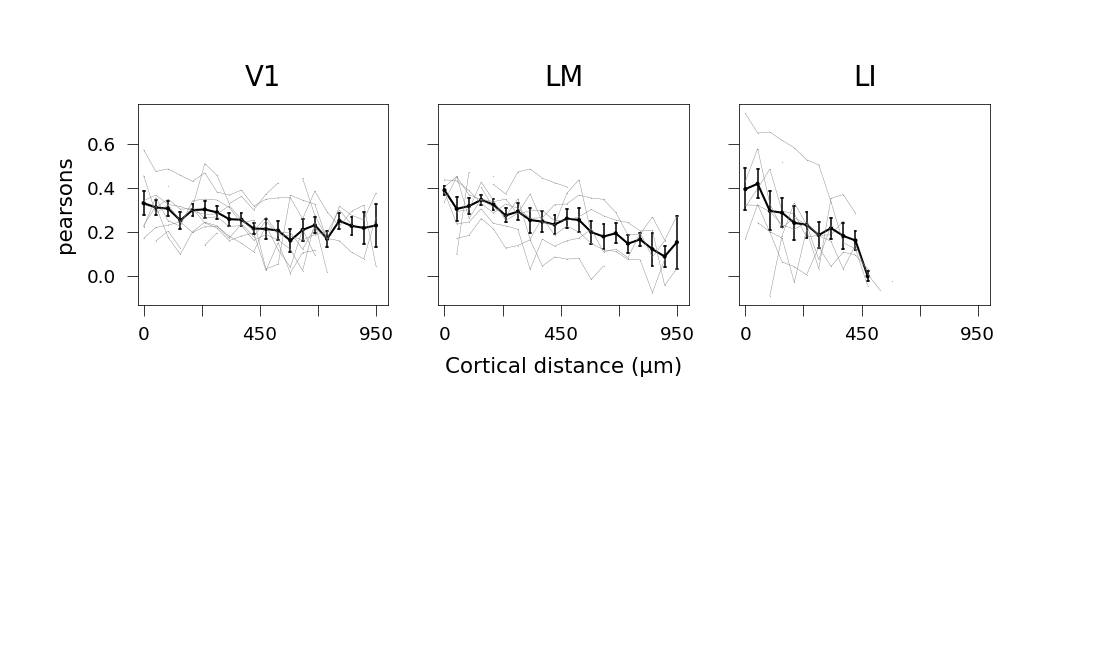

In [130]:
x_var = 'cortical_distance'
y_var = 'pearsons'

if x_var == 'area_overlap':
    xlabel = 'RF overlap (%)'
else:
    xlabel = 'RF distance (deg.)' if x_var == 'rf_distance'\
            else 'Cortical distance (\u00b5m)'

# Find the max. bin number where neuron_pair is non-zero
# counts_per_bin = morph_pos_df.groupby(['visual_area', 'datakey', 'binned_{}'.format(x_var)])\
#                         ['neuron_pair'].count().reset_index()
# populated_bins = counts_per_bin[counts_per_bin['neuron_pair']>n_combos]
# max_populated_bin = populated_bins.groupby('visual_area')['binned_{}'.format(x_var)].max()

# plot
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(5, 3))
ax=axn[0]
incl_vg_list = []
for va, vg in filtered.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    #max_bin = max_populated_bin.loc[va]
    #incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin]
    #incl_vg_list.append(incl_vg)
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax,  palette=mono_cdict, errorbar=None, #('ci', 95),
                scale=0.05, markers='.', errwidth=0.25)
    ax.legend_.remove() #sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
#     ax.set_box_aspect(1)
    ax.set_title(va.upper())
    ax.set_xlabel('Cortical distance (um)')
    ax.set_ylabel('Tuning similarity')

# Plot MEAN
for va, vg in dk_means.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    #max_bin = max_populated_bin.loc[va]
    incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin_va.loc[va]]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, 
            data=incl_vg, ax=ax, errorbar='se',
            color='k', markers='.', scale=0.25, errwidth=0.5, capsize=0.15)
    ax.set_zorder(5000)  # Adjust the value as needed
    ax.set_box_aspect(1)
    ax.set_ylabel('{}'.format(y_var)) if va=='V1' else ax.set_ylabel('')
    ax.set_xlabel(xlabel) if va=='Lm' else ax.set_xlabel('')

    xlabels = sorted(incl_vg['binned_{}'.format(x_var)].unique())
    xticks = np.linspace(0, len(xlabels)-1, 5)
    xtick_labels = [int(xlabels[int(x)]) if i%2==0 or i==len(xticks)-1 
                else "" for i, x in enumerate(xticks)]
    ax.set_xlim([-0.5, np.argmax(xlabels) +1])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
# Format
pl.subplots_adjust(bottom=0.5)

figname = 'each_FOV_{}_vs_{}_ctxmaxdist-{}um_mono'.format(x_var, y_var, ctx_maxdist)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

#### stats

In [98]:
from itertools import combinations
import statsmodels.stats.multitest as smm

In [124]:
x_var = 'cortical_distance'
y_var = 'pearsons'
s_list = []
i=0
for va, vg in morph_pos_df.groupby('visual_area'):
    for d, d_vg in vg.groupby('datakey'):
        X = d_vg[x_var].values
        y = d_vg[y_var].values
        slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
        if np.isnan(p_value):
            continue
        print('{}: r={:.2f}, p={:.2f}'.format(d, r_value, p_value))
        stat = pd.DataFrame({'visual_area': va, 'datakey': d,
                      'slope': slope,
                      'intercept': intercept,
                      'pearson_r': r_value,
                      'p_value': p_value,
                      'std_err': std_err}, index=[i])
        s_list.append(stat)
        i+=1
statdf = pd.concat(s_list)

20190315_JC070_fov1: r=-0.44, p=0.00
20190316_JC070_fov1: r=-0.03, p=0.98
20190322_JC073_fov1: r=-0.22, p=0.00
20190422_JC076_fov1: r=-0.13, p=0.22
20190602_JC091_fov1: r=-0.39, p=0.00
20190606_JC091_fov1: r=-0.22, p=0.00
20190609_JC099_fov1: r=-0.12, p=0.01
20190617_JC099_fov1: r=-0.19, p=0.72
20191018_JC113_fov1: r=-0.41, p=0.00
20191111_JC120_fov1: r=-0.02, p=0.78
20190322_JC073_fov1: r=-0.40, p=0.00
20190422_JC076_fov1: r=-0.10, p=0.46
20190430_JC078_fov1: r=-0.23, p=0.00
20190504_JC078_fov1: r=-0.06, p=0.20
20190506_JC080_fov1: r=-0.11, p=0.00
20190508_JC083_fov1: r=-0.07, p=0.01
20190525_JC084_fov1: r=-0.10, p=0.00
20190618_JC097_fov1: r=-0.07, p=0.38
20190627_JC091_fov1: r=-0.13, p=0.00
20190501_JC076_fov1: r=-0.13, p=0.06
20190507_JC083_fov1: r=-0.18, p=0.00
20190512_JC083_fov1: r=-0.13, p=0.13
20190522_JC084_fov1: r=-0.12, p=0.00
20190613_JC097_fov1: r=-0.04, p=0.14
20190616_JC097_fov1: r=-0.13, p=0.00
20190617_JC097_fov1: r=-0.16, p=0.00
20190622_JC085_fov1: r=-0.02, p=0.23
2

In [125]:
stat_var = 'slope'
#perform Kolmogorov-Smirnov test
results = {}
groups = ['V1', 'Lm', 'Li']
k_ = []
for group1, group2 in combinations(groups, 2):
    ks_stat, p_value = spstats.mannwhitneyu(
                statdf[statdf['visual_area']==group1][stat_var], 
                statdf[statdf['visual_area']==group2][stat_var],
                alternative='greater')
    results[f"{group1} vs {group2}"] = (ks_stat, p_value)

# Apply Bonferroni correction
adjusted_p_values = smm.multipletests([r[1] for r in 
                                       results.values()], method='fdr_bh')[1]
# Print results
for (comparison, (ks_stat, p)), adj_p in zip(results.items(), adjusted_p_values):
    print(f"{comparison}: KS-stat = {ks_stat:.2f}, p = {p:.2f}, adjusted p = {adj_p:.2e}")
    ks = pd.DataFrame({'comparison': comparison,
                 'ks_stat': ks_stat,
                 'p': p,
                 'adjusted_p': adj_p}, index=[i])
    i+=1
    k_.append(ks)
sigdf = pd.concat(k_).reset_index(drop=True)
sigdf['A'] = [c.split(' ')[0] for c in sigdf['comparison']]
sigdf['B'] = [c.split(' ')[-1] for c in sigdf['comparison']]
sigdf

V1 vs Lm: KS-stat = 52.00, p = 0.17, adjusted p = 1.66e-01
V1 vs Li: KS-stat = 74.00, p = 0.01, adjusted p = 2.99e-02
Lm vs Li: KS-stat = 67.00, p = 0.04, adjusted p = 5.94e-02


comparison  ks_stat         p  adjusted_p   A   B
0   V1 vs Lm     52.0  0.165694    0.165694  V1  Lm
1   V1 vs Li     74.0  0.009982    0.029947  V1  Li
2   Lm vs Li     67.0  0.039590    0.059385  Lm  Li

<IPython.core.display.Javascript object>


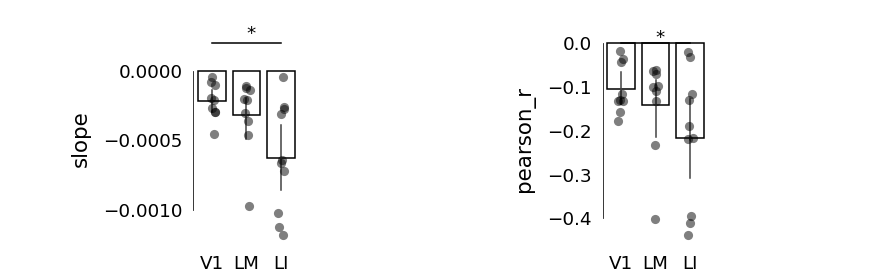

In [131]:
fig, axn = pl.subplots(1, 2, figsize=(4,1.25))
for ai, yv in enumerate(['slope', 'pearson_r']):
    ax=axn[ai]
    sns.barplot(statdf, x='visual_area', y=yv,ax=ax,
                  order=visual_areas, edgecolor='k', facecolor='none',
                errwidth=0.5, linewidth=0.5)
    sns.stripplot(statdf, x='visual_area', y=yv,ax=ax,
                  order=visual_areas, color='k', #hue='p_color', palette=p_cdict, 
                  size=3, alpha=0.5)
    ax.set_box_aspect(2)
    pplot.annotate_multicomp_by_area(ax, sigdf,p_var='adjusted_p',
                                     offset=0.0002)
    ax.tick_params(length=0)
    ax.set_xlabel('')
    ax.set_xticklabels(['V1', 'LM', 'LI'])
sns.despine(trim=True, bottom=True)

pl.subplots_adjust(right=0.9, wspace=0.5)

figname = 'each_FOV_{}_vs_{}_ctxmaxdist-{}um_stats'.format(x_var, y_var, ctx_maxdist)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [127]:
figname

'each_FOV_cortical_distance_vs_pearsons_ctxmaxdist-1000um_stats'

# RFs

In [138]:
# curr_corrs = CORRS[CORRS['visual_area']=='Li'].copy()
ctx_maxdist = 1000
ctx_mindist= 30
currcorrs = DISTS[(DISTS.cortical_distance<=ctx_maxdist)
                  & (DISTS.cortical_distance>=ctx_mindist)
          ].copy().dropna()
# Cut bins
currcorrs, dist_lut = cr.get_bins_and_cut(currcorrs, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)

In [139]:
DISTS.columns

Index(['xcorr_morph', 'pearsons_morph', 'cosim_morph', 'cell_1', 'cell_2',
       'neuron_pair', 'xcorr_size', 'pearsons_size', 'cosim_size',
       'max_response', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance', 'rf_angle_diff', 'rf_angle_diff_abs', 'std_x',
       'std_y', 'aspect_ratio', 'area_overlap', 'perc_overlap',
       'overlap_index', 'visual_area', 'datakey', 'n_cells'],
      dtype='object')

<IPython.core.display.Javascript object>


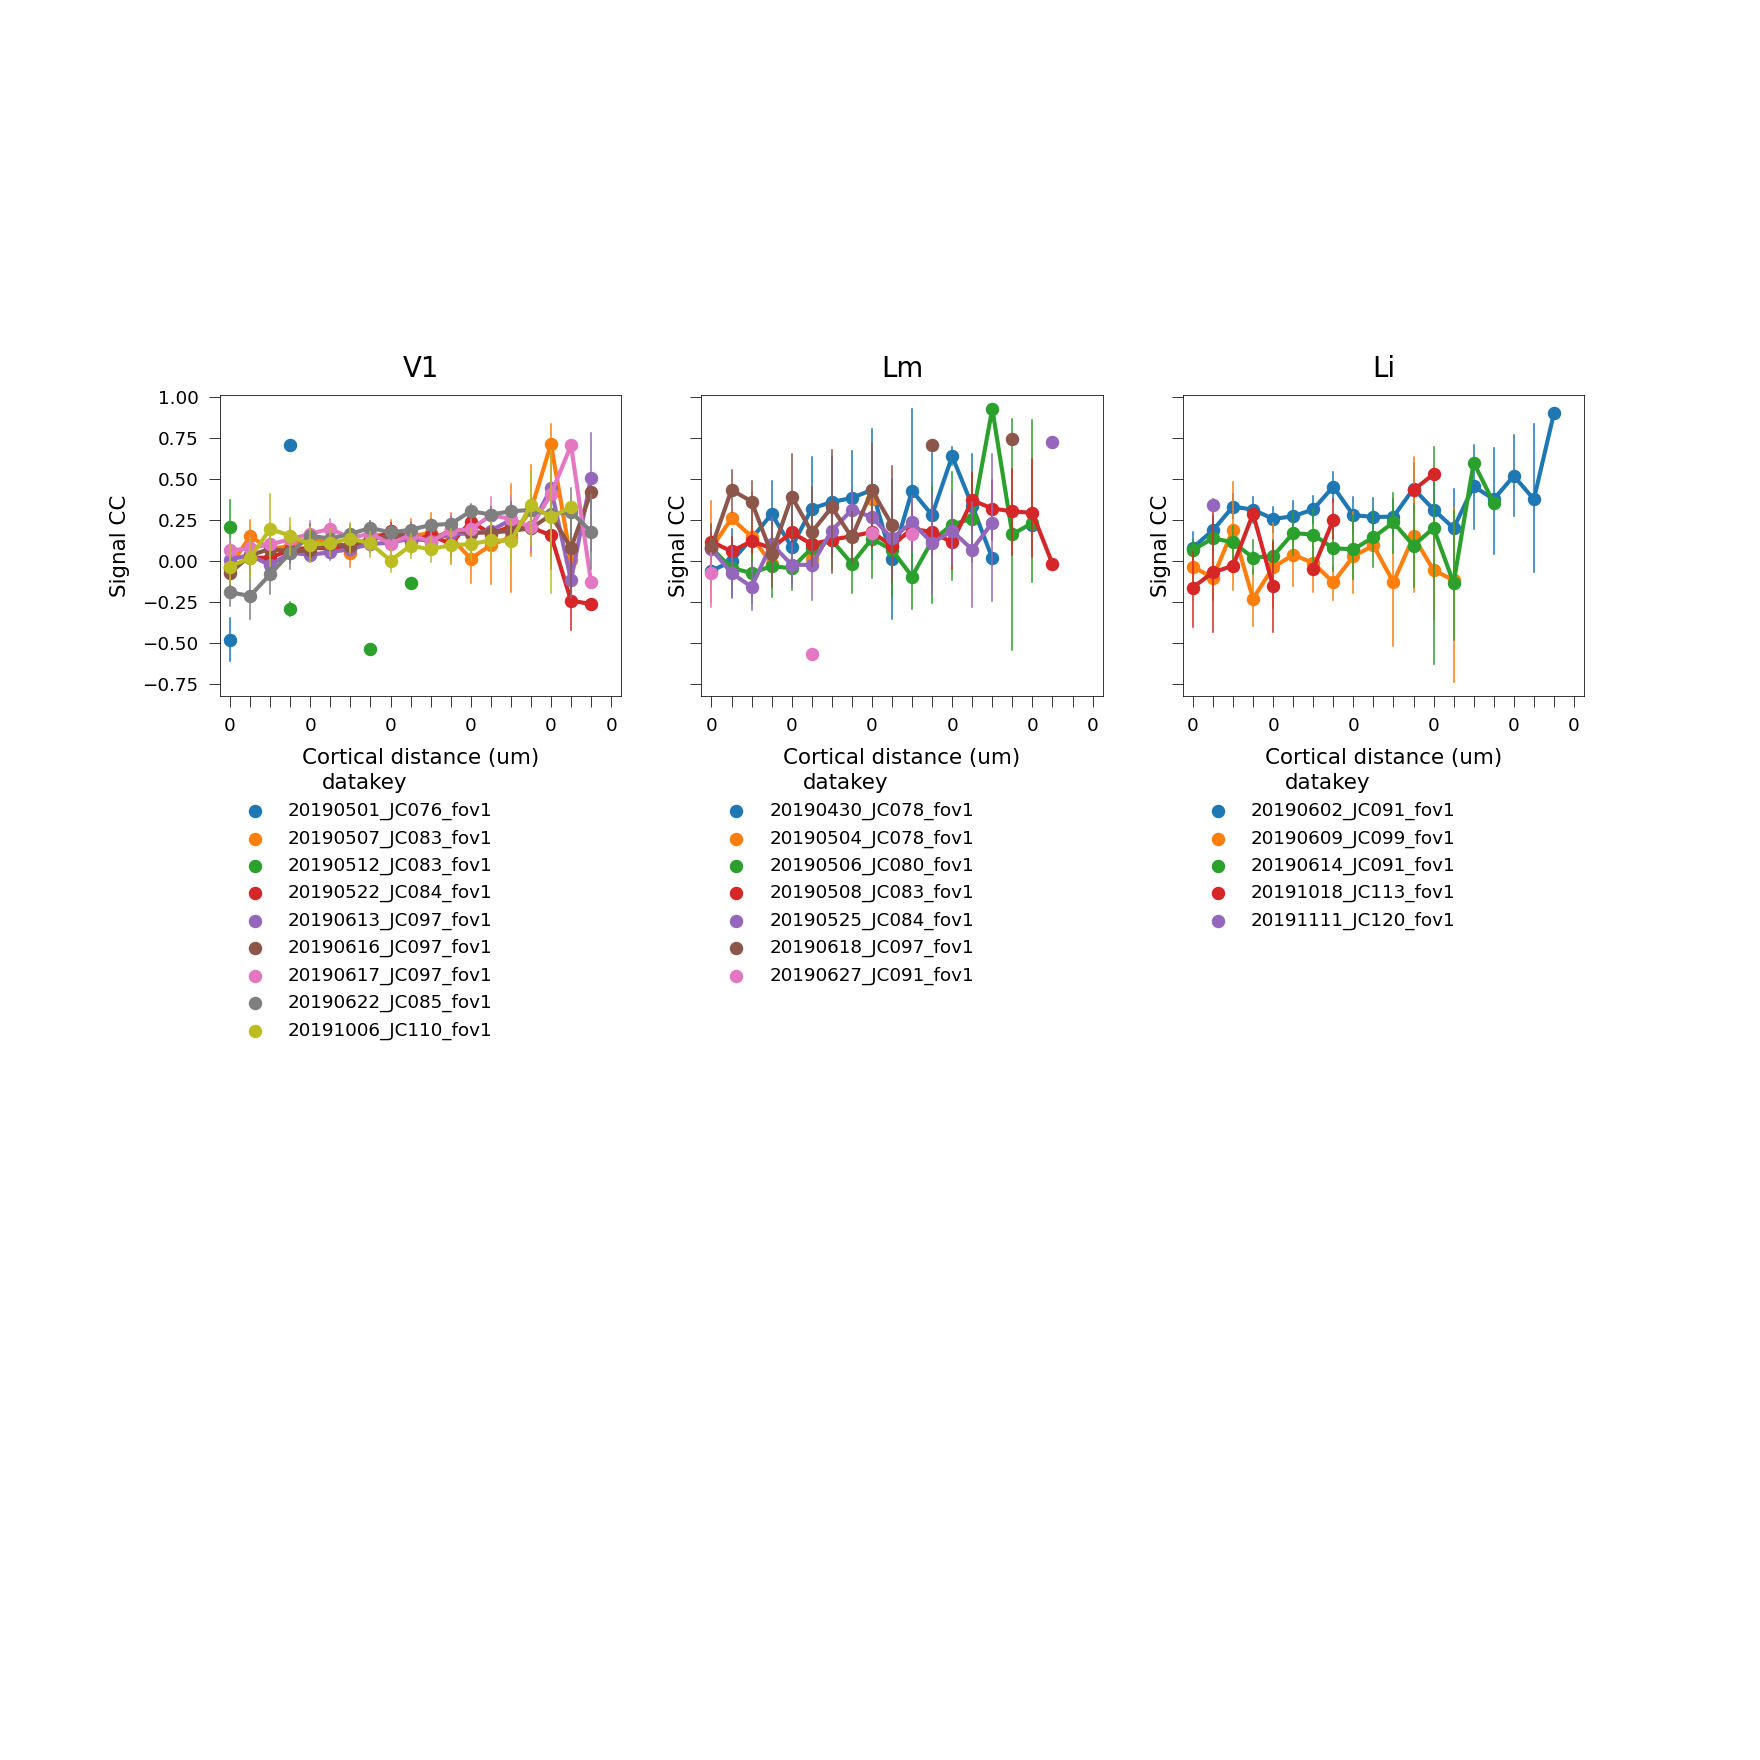

[Text(0, 0, '0'),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, '0'),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, '0'),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, '0'),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, '0'),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, '0')]

In [140]:
x_var = 'area_overlap'
y_var = 'pearsons_morph'

#curr_plotdf = currcorrs[currcorrs['visual_area']=='Li'].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(8, 8))
ax=axn[0]
for va, vg in currcorrs.groupby('visual_area'):

    ax=axn[visual_areas.index(va)]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax, errorbar=('ci', 95),
                scale=0.5, errwidth=0.5)
    sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
    ax.set_box_aspect(0.75)
    ax.set_title(va)
    ax.set_xlabel('Cortical distance (um)')
    ax.set_ylabel('Signal CC')
#x_bins = sorted(curr_plotdf['%s_label' % x_var].unique())
pl.subplots_adjust(bottom=0.5)
xbins = sorted([i for i in dist_lut[x_var]['bins'] if i<=ctx_maxdist])
xticks = ax.get_xticks()
#ax.set_xticks(xticks-0.5)
ax.set_xticklabels([int(xbins[i]) if i in xticks[0::4] or i==xticks[-1] \
                    else '' for i in xticks])


# figname = 'each_FOV_{}_vs_{}_fovs'.format(x_var, y_var)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [24]:
cc_outfile = os.path.join(dst_dir, 'ccdist.pkl')
with open(cc_outfile, 'wb') as f:
    pkl.dump(f, cc_outfile)
    

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-none_rfs-dff-uncorr.pkl


In [26]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

#### Average signal/noise ccs. by FOV

<IPython.core.display.Javascript object>


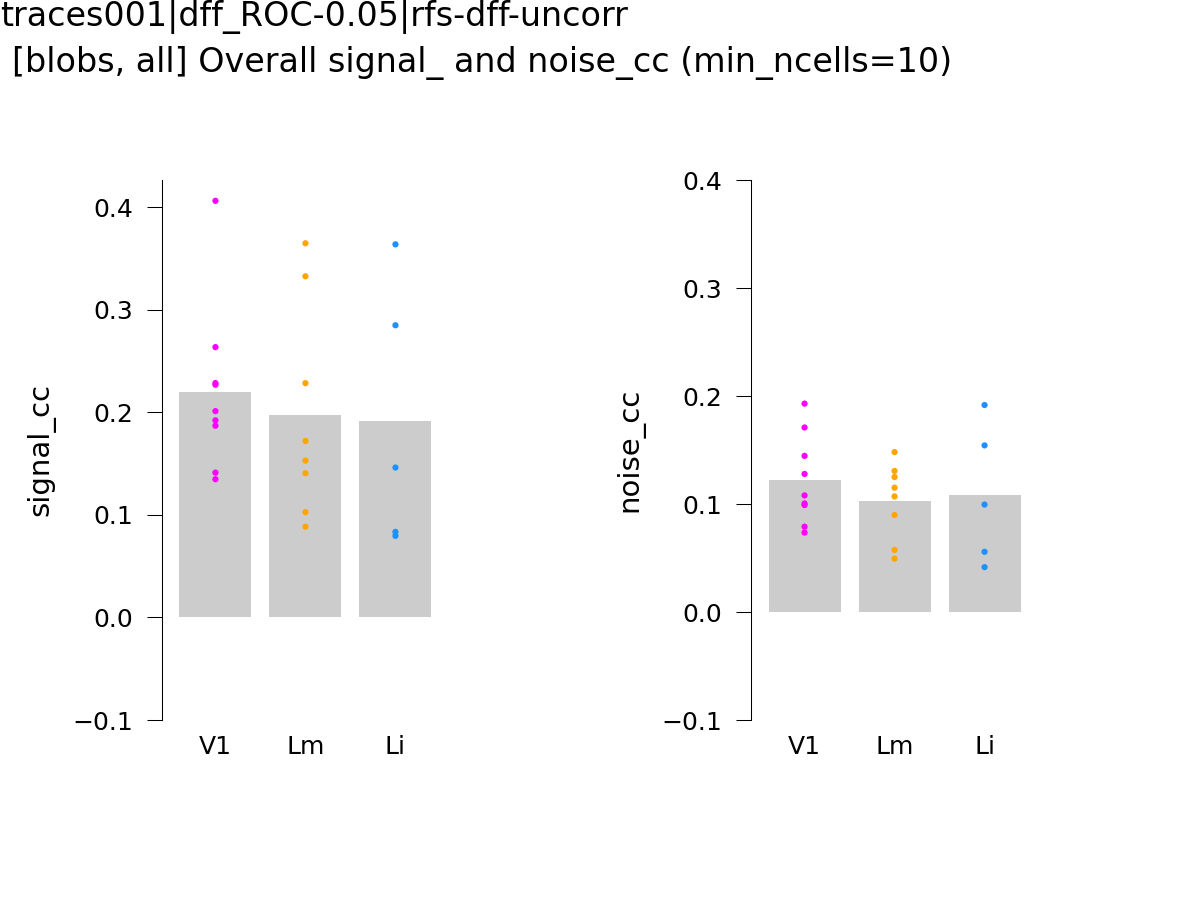

0
1
    A   B  p-unc  p-corr p-adjust     metric
0  V1  Lm   0.42     1.0   fdr_by  signal_cc
1  V1  Li   0.61     1.0   fdr_by  signal_cc
2  Lm  Li   0.62     1.0   fdr_by  signal_cc
0  V1  Lm   0.54     1.0   fdr_by   noise_cc
1  V1  Li   0.61     1.0   fdr_by   noise_cc
2  Lm  Li   1.00     1.0   fdr_by   noise_cc


In [49]:
%matplotlib notebook
ymin, ymax = [-0.1, 0.4]
posthoc='fdr_by'
corrs_fov = CORRS.groupby(['visual_area', 'datakey']).median().reset_index()
fig, axn =pl.subplots(1, 2, figsize=(4,3), dpi=150, sharey=False)
stat_list=[]
for ci, metric in enumerate(['signal_cc', 'noise_cc']):
    ax=axn[ci]
    print(ci)
    ax, stats_ = pplot.stripplot_metric_by_area(corrs_fov, metric=metric, ax=ax,
                markersize=3,area_colors=area_colors,mean_style='bar', 
                posthoc=posthoc, return_stats=True,
                mean_type='mean', y_loc=0.3, jitter=False, aspect=2)

    stats_['metric'] = metric
    stat_list.append(stats_)
    ax.set_yticks(np.linspace(ymin, ymax, 6))
fig.text(0.01, 0.92, '[%s, %s] Overall signal_ and noise_cc (min_ncells=%i)' 
         % (experiment, select_stimuli, min_ncells), fontsize=8)

statsdf_cc = pd.concat(stat_list, axis=0)

pplot.label_figure(fig, data_id)
figname = 'overall_sig_and_noise_cc_byFOV' 
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(statsdf_cc.round(2))


In [65]:
7.1/2.5

2.84

In [306]:
import analyze2p.utils as util

In [40]:
curr_lim = 15
very_close = DISTS[DISTS['cortical_distance']<curr_lim].copy()
very_close

xcorr_morph  pearsons_morph  cosim_morph  cell_1  cell_2 neuron_pair  \
252        2.587239        0.612241     0.923448     266     329     266_329   
492        5.690129        0.981396     0.999123      15      16       15_16   
987        4.658047        0.185048     0.961345      27      28       27_28   
1066       5.197616        0.922606     0.995552      28      29       28_29   
1519       3.709380        0.860889     0.980382      38      39       38_39   
...             ...             ...          ...     ...     ...         ...   
133482     5.063604        0.871614     0.993080     103     104     103_104   
134437     3.224277        0.466076     0.921594     170     182     170_182   
135066     5.223506        0.781897     0.990032     240     242     240_242   
135352     3.542522        0.525248     0.955802     285     298     285_298   
135404     4.180847       -0.216185     0.898241     301     364     301_364   

        xcorr_size  pearsons_size  cosim_size  max_response  ...  \
252       1.682026       0.941864    0.974186      0.000990  ...   
492       1.927878       0.979531    0.990862      0.031955  ...   
987       1.490198      -0.206089    0.739619      0.049804  ...   
1066      1.815851       0.984414    0.992678      0.056536  ...   
1519      2.111788       0.803391    0.951836      0.065982  ...   
...            ...            ...         ...           ...  ...   
133482    1.563895       0.894929    0.963833      0.180326  ...   
134437    1.658808      -0.679637    0.797383      0.040804  ...   
135066    1.557803       0.969992    0.987821      0.326497  ...   
135352    2.162529       0.874967    0.983723      0.023925  ...   
135404    2.126892       0.989548    0.956589      0.036029  ...   

        rf_angle_diff_abs     std_x     std_y  aspect_ratio  area_overlap  \
252                   NaN       NaN       NaN           NaN           NaN   
492              4.403186  4.711111  2.646786      0.072537      0.553561   
987                   NaN       NaN       NaN           NaN           NaN   
1066                  NaN       NaN       NaN           NaN           NaN   
1519             6.760472  1.853583  3.759288      0.270798      0.768286   
...                   ...       ...       ...           ...           ...   
133482          13.892440  1.120980  1.181104      0.120081      0.655717   
134437                NaN       NaN       NaN           NaN           NaN   
135066                NaN       NaN       NaN           NaN           NaN   
135352                NaN       NaN       NaN           NaN           NaN   
135404                NaN       NaN       NaN           NaN           NaN   

        perc_overlap  overlap_index  visual_area              datakey  n_cells  
252              NaN            NaN           Li  20190422_JC076_fov1       29  
492         0.999294       0.446439           Li  20190602_JC091_fov1       87  
987              NaN            NaN           Li  20190602_JC091_fov1       87  
1066             NaN            NaN           Li  20190602_JC091_fov1       87  
1519        0.957930       0.231714           Li  20190602_JC091_fov1       87  
...              ...            ...          ...                  ...      ...  
133482      0.905315       0.344283           V1  20191006_JC110_fov1       86  
134437           NaN            NaN           V1  20191006_JC110_fov1       86  
135066           NaN            NaN           V1  20191006_JC110_fov1       86  
135352           NaN            NaN           V1  20191006_JC110_fov1       86  
135404           NaN            NaN           V1  20191006_JC110_fov1       86  

[98 rows x 25 columns]

In [35]:
import analyze2p.utils as util

In [43]:
dk = '20191006_JC110_fov1'
session, animalid, fov = util.split_datakey_str(dk)
masks, zimg = roiutils.load_roi_masks(animalid, session, fov, rois='rois001',
                                      rootdir=rootdir)
if masks.min()==0:
    masks[masks==0] = np.nan
print(masks.shape)

(391, 512, 512)


In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


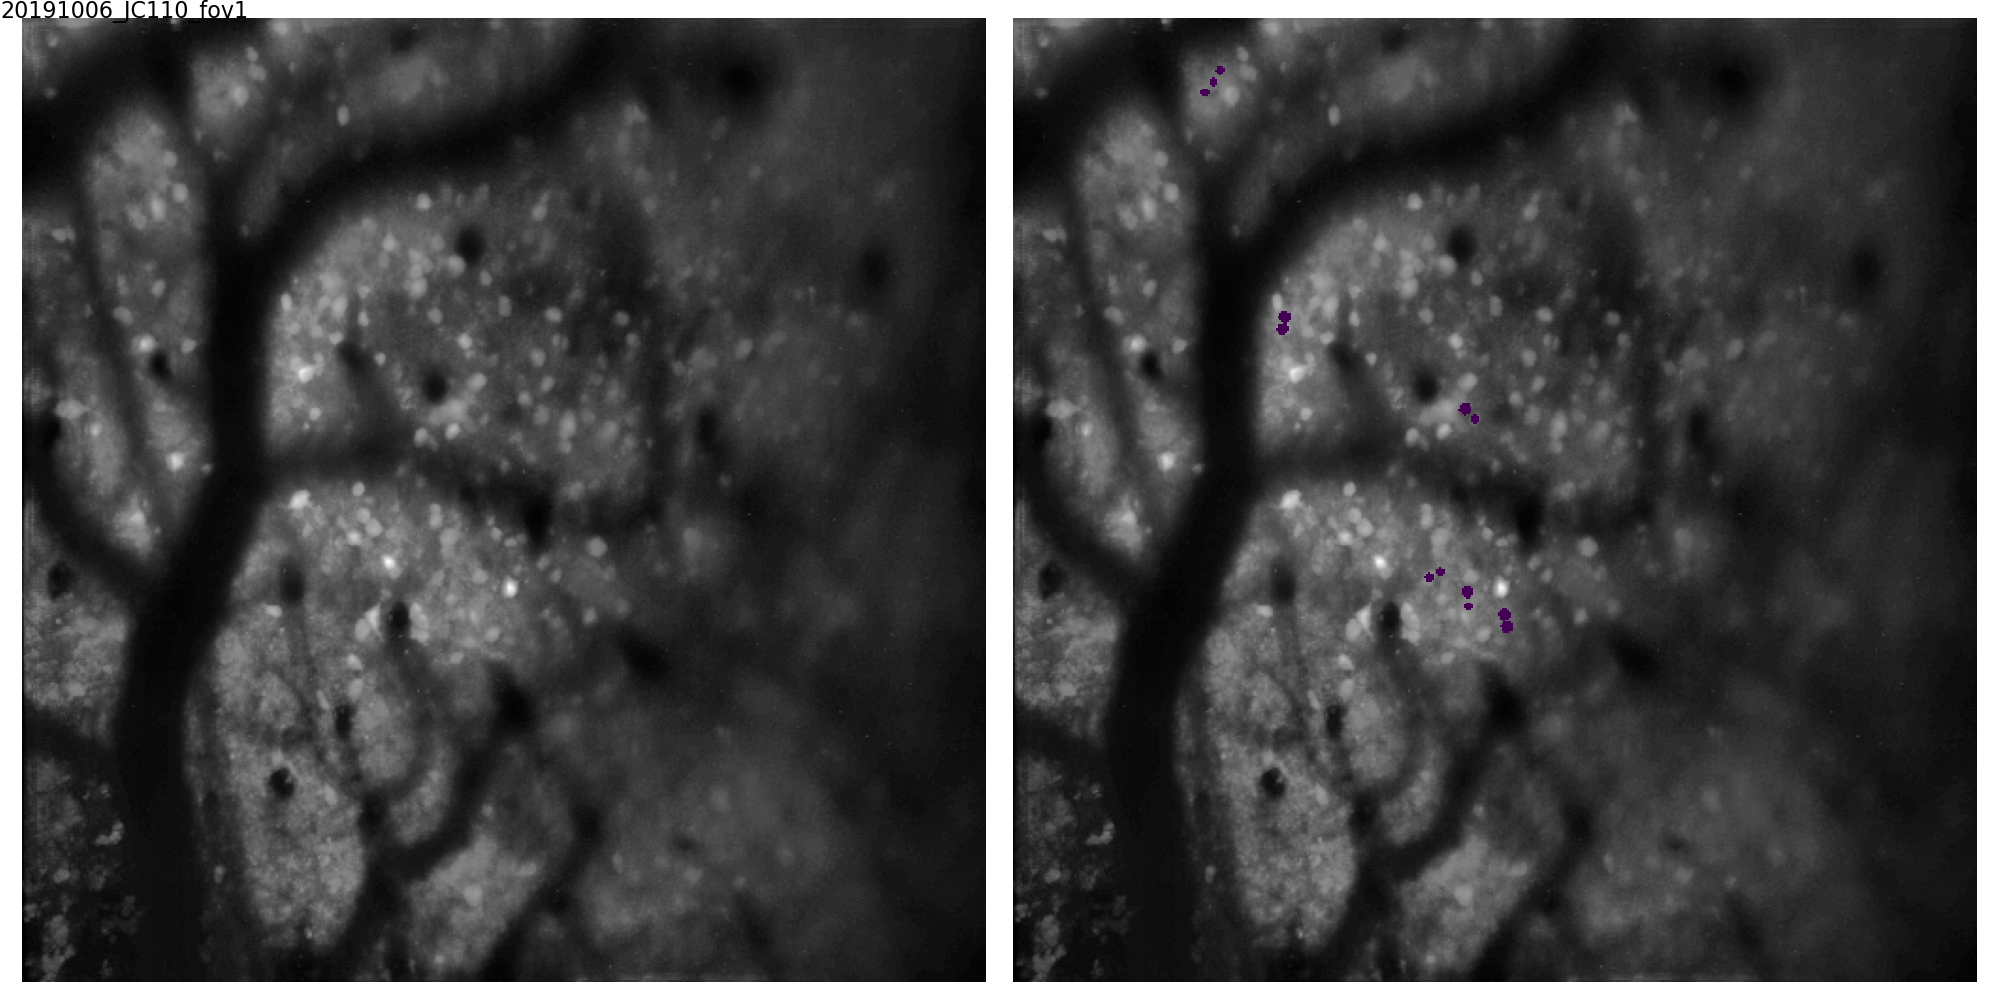

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR example-nearby-cells_less-than-15_20191006_JC110_fov1


In [46]:
fig, axn = pl.subplots(1, 2, figsize=(10,5))
for ax in axn:
    surface_2p = pplot.adjust_image_contrast(zimg, clip_limit=5.0, tile_size=5)
    ax.imshow(surface_2p, cmap='gray')
    ax.axis('off')
# r1 = rois[0] #rois = [57, 67]
for i, v in very_close[very_close['datakey']==dk].iterrows():
    rois = v[['cell_1', 'cell_2']]
    for roi in rois:
        im = masks[roi, :, :].copy()
        msk = np.ma.masked_where( np.isnan(im), im)
        ax.imshow(msk)
pl.tight_layout()

pplot.label_figure(fig, dk)
figname = 'example-nearby-cells_less-than-{}_{}'.format(curr_lim, dk)
pl.savefig(os.path.join(FIGDIR, '{}.png'.format(figname)))
print(FIGDIR, figname)

#### Distance as a function of signal/noise cc

<IPython.core.display.Javascript object>


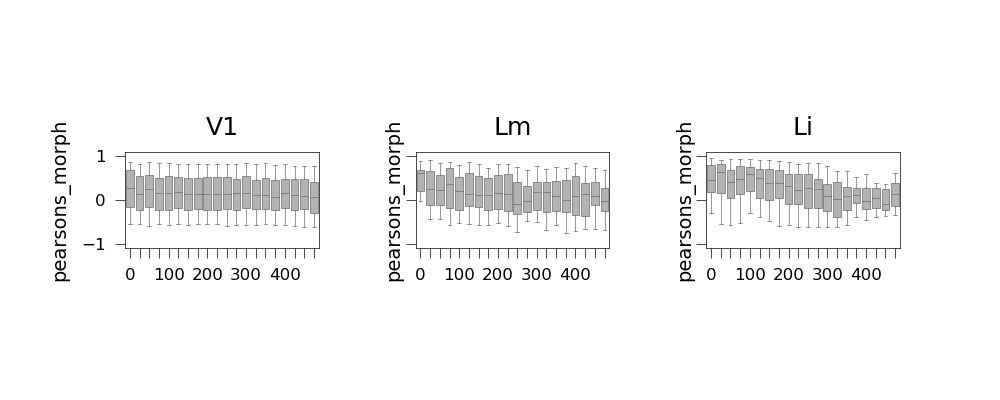

NameError: name 'select_stimuli' is not defined

In [51]:
%matplotlib notebook
ctx_maxdist = 500
df = DISTS[(DISTS.cortical_distance<=ctx_maxdist)
          ].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# ------------------------------------------------------------
# metric_vars = ['signal_cc', 'noise_cc']
metric_vars = ['pearsons_morph']
x_var = 'cortical_distance'
fig, axn =pl.subplots(len(metric_vars), 3,figsize=(5,2), dpi=100, sharex=True, sharey=True)
for vi, (va, v_df) in enumerate(df.groupby('visual_area')):
    ci = visual_areas.index(va)
    for ri, y_var in enumerate(metric_vars):
        #x_bins = dist_lut[dist_var]['bins']
        x_bins = sorted(v_df['binned_%s' % x_var].unique())
        xticks=np.arange(0, len(x_bins))
        ax=axn[ri, ci] if len(metric_vars)>1 else axn[ci]
        if ri==0:
            ax.set_title(va)
        sns.boxplot(y='{}'.format(y_var), x='binned_{}'.format(x_var),
                    data=v_df, ax=ax, color=[0.7]*3, linewidth=0.25,
                    fliersize=0, whis=(5, 95))
#                 errwidth=0.5)
#         sns.stripplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, 
#                       s=1, alpha=0.5, color='k')
        ax.set_xticks(xticks)
        ax.set_xticklabels([int(round(x_bins[i], 1)) if i in xticks[0::4] else ''
                           for i in xticks])
        ax.set_box_aspect(0.5)
for ax in axn.flat:
    ax.set_xlabel('')
pl.subplots_adjust(bottom=0.2, right=0.9, wspace=0.5, hspace=0.3, top=0.8)
fig.text(0.01, 0.92, '[%s, %s] Avg. distance metrics (max_dist=%i um)' 
         % (experiment, select_stimuli, ctx_maxdist), fontsize=8)
pplot.label_figure(fig, data_id)

#### Binned distance, compare SIGNAL_CC (and shuffle)

In [32]:
ctx_maxdist = 500
y_var='signal_cc'
dist_var='cortical_distance'
cmap='viridis'
tuned_or_resp = 'responsive'
# ----------------------------------
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# Shuffle
combined_ = cr.shuffle_bins_by_area(df, dist_var=dist_var, n_iterations=100)

# Plot shuffled to check
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   data=combined_[combined_.condition=='shuffled'])
fg.map(sns.barplot, '%s_label' % dist_var, 'signal_cc' , ci='sd')
pl.subplots_adjust(bottom=0.2, right=0.8)

100.0


<IPython.core.display.Javascript object>


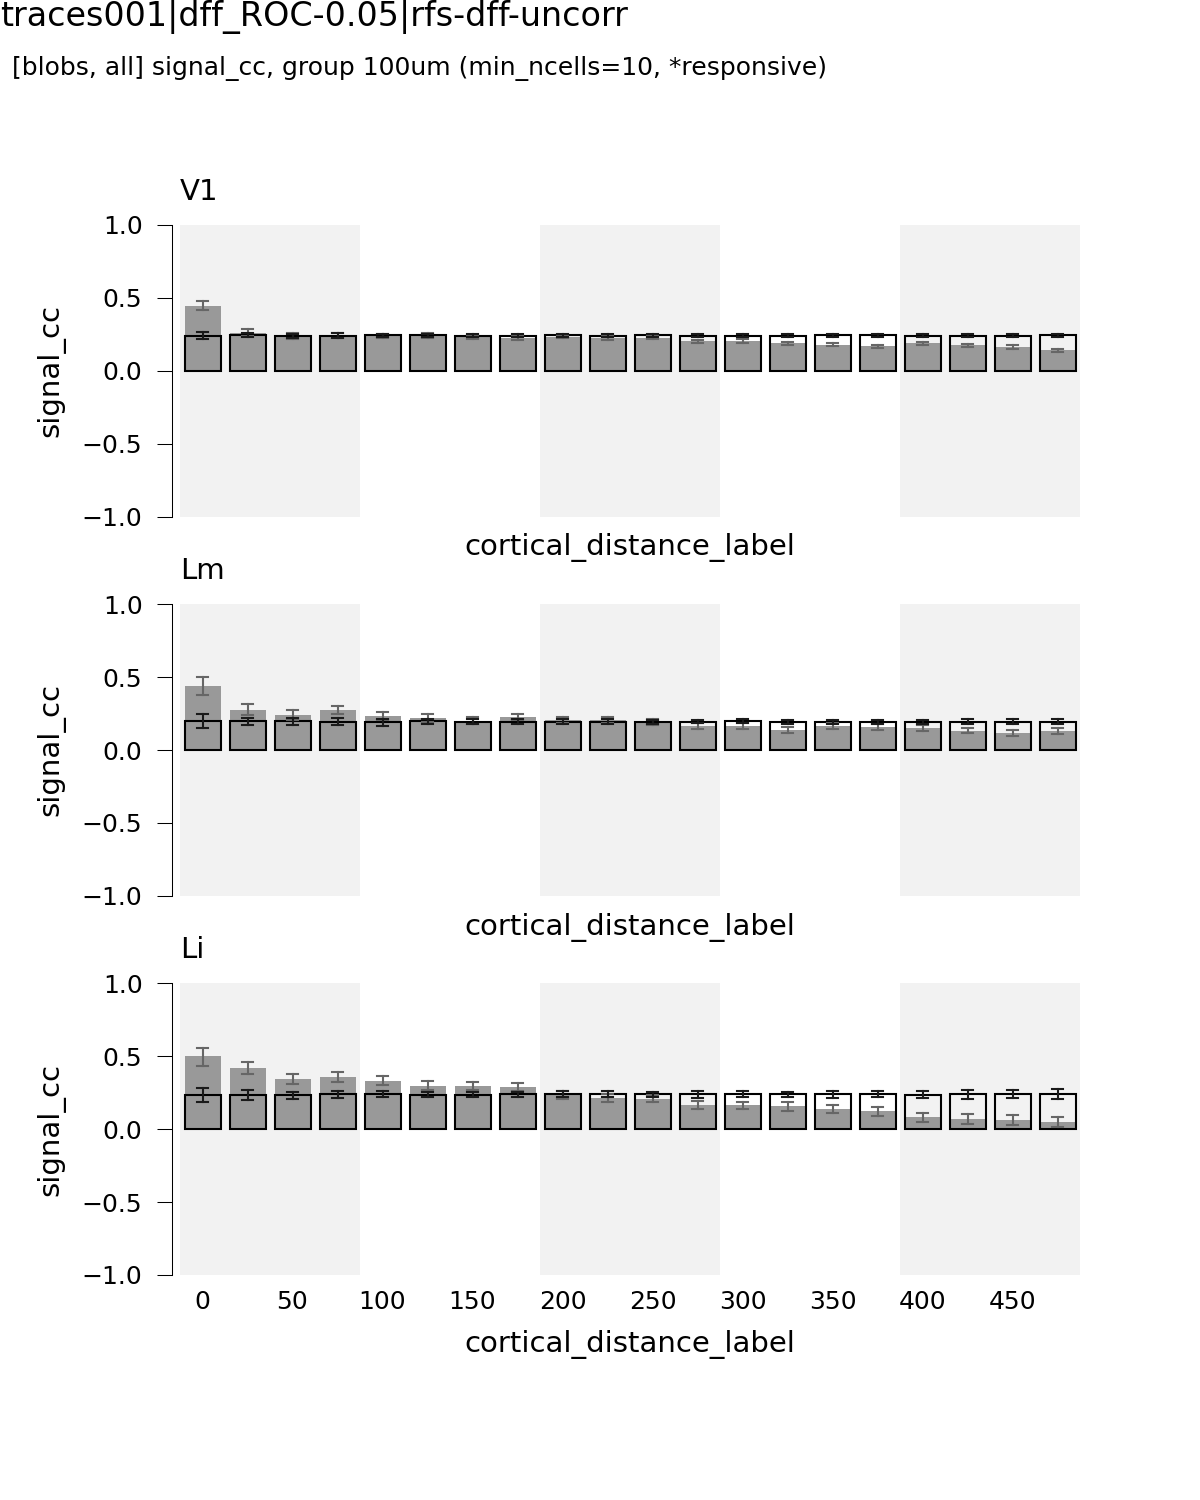

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr binned-dist-bar_signal_cc_v_cortical_distance_responsive_max500


In [215]:
dist_unit='um'
curr_maxdist = dist_lut[dist_var]['max_dist']
plot_pairs=False
# curr_maxdist=60 if dist_var=='rf_distance' else 500
plot_str = '_wpairs' if plot_pairs else ''
sorted_x_vars =  dist_lut[dist_var]['bins']
bin_width = 4 if dist_var=='cortical_distance' else 5
patch_step = sorted_x_vars[bin_width] #+dist_lut[dist_var]['step']
print(patch_step)
%matplotlib notebook
fig = cr.barplot_with_shuffled_distbins(combined_, dist_var, y_var,
                     curr_maxdist=curr_maxdist, round_x=0, dist_unit=dist_unit,
                     barcolor=[0.6]*3, errcolor=[0.4]*3, errcolor_shuffled=[0.1]*3,
                     plot_pairs=plot_pairs,figsize=(4,5),
                     draw_group_patch=True, bin_width=bin_width)
sns.despine(bottom=True, trim=True, offset=2)
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.85, hspace=0.3)
fig.text(0.01, 0.95, "[%s, %s] %s, group %i%s (min_ncells=%i, *%s)" \
         % (experiment, select_stimuli, y_var, \
            patch_step, dist_unit, min_ncells, tuned_or_resp))

pplot.label_figure(fig, data_id)
figname = 'binned-dist-bar_%s_v_%s_%s_max%i%s' \
            % (y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(dst_dir, figname)

In [216]:
far_bins

[]

In [220]:
plotd = combined_[(combined_.condition=='data') 
                & (combined_.cortical_distance<=curr_maxdist)]
# y_var='signal_cc'
print(y_var, dist_var)
near_lim = (0, 50)
upper_lim = (50, 150)

near_bins = [b for b in dist_lut[dist_var]['bins'] if near_lim[0]<=b<near_lim[1]]
far_bins = [b for b in dist_lut[dist_var]['bins'] \
           if (b>=upper_lim[0]) and (b<upper_lim[1])]
print("NEAR:", near_bins)
print("FAR:", far_bins)

col1='r' #[0.3]*3
col2='b' #[0.8]*3
curr_dist_colors = dict((k, v) for k, v in zip(['near', 'far'], [col1, col2]))

v1df = plotd[plotd['%s_label' % dist_var].isin(near_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
v2df = plotd[plotd['%s_label' % dist_var].isin(far_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
print(len(v1df), len(v2df))
v1df['distance_cond'] = 'near'
v2df['distance_cond'] = 'far'

dist_df = pd.concat([v1df, v2df], axis=0, ignore_index=True)


signal_cc cortical_distance
NEAR: [0.0, 25.0]
FAR: [50.0, 75.0, 100.0, 125.0]
2247 11129


<IPython.core.display.Javascript object>


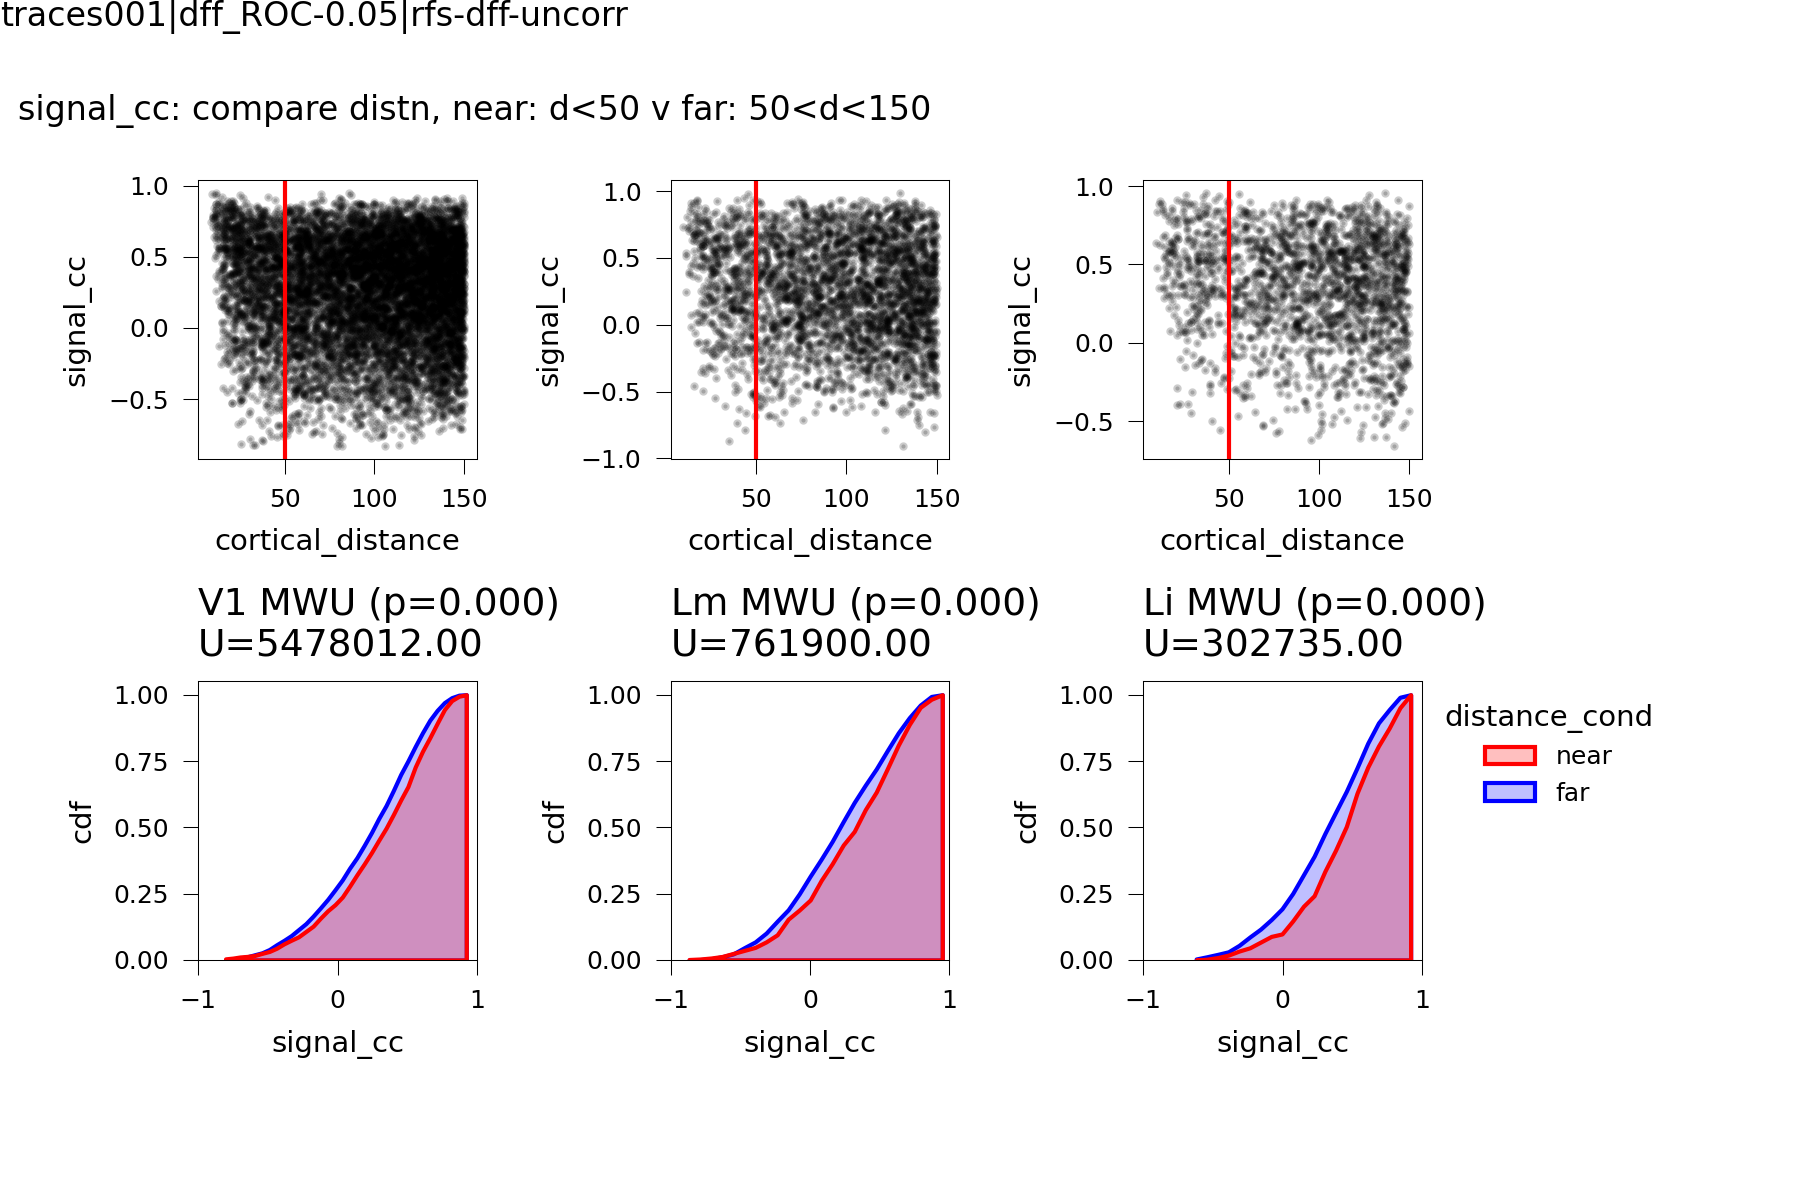

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr compare-bins_near50_far50_signal_cc_v_cortical_distance_responsive_max500


In [223]:
fig, axn = pl.subplots(2, 3, sharex=False, sharey=False, figsize=(6,4), dpi=150)
for va, vg in dist_df.groupby('visual_area'):
    ax=axn[0, visual_areas.index(va)]
    ax.scatter(x=dist_var, y=y_var, data=vg, s=1, color='k', alpha=0.2)
    ax.set_xlabel(dist_var)
    ax.set_ylabel(y_var)
    ax.axvline(x=near_lim[-1], color='r', ls='-', lw=1)
    
    ax=axn[1, visual_areas.index(va)]
    sns.histplot(x=y_var, data=vg, hue='distance_cond', ax=ax,
                 palette=curr_dist_colors, cumulative=True, common_norm=False,
                stat='probability', element='poly', lw=1)
    if va=='Li':
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1,1), loc='upper left',
                  frameon=False)
    else:
        ax.legend_.remove()
    ax.set_xlim([-1, 1])
    v1 = vg[vg.distance_cond=='near'][y_var].values
    v2 = vg[vg.distance_cond=='far'][y_var].values
    U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
    ax.set_ylabel('cdf')
    ax.set_title('%s MWU (p=%.3f)\nU=%.2f' % (va, p, U), loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.8, bottom=0.2, top=0.85, 
                   hspace=0.8)
fig.text(0.01, 0.9, '%s: compare distn, near: d<%i v far: %i<d<%i' \
             % (y_var, near_lim[-1], upper_lim[0], upper_lim[-1]), fontsize=8)
pplot.label_figure(fig, data_id)

figname = 'compare-bins_near%i_far%i_%s_v_%s_%s_max%i%s' \
            % (near_lim[-1], upper_lim[0], y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)

In [180]:
near_bins

[0.0, 25.0]

In [181]:
far_bins

[50.0, 75.0]

In [49]:
curr_maxdist = 250
plotd = combined_[(combined_.condition=='data') 
                & (combined_.cortical_distance<=curr_maxdist)]
# y_var='signal_cc'
print(y_var, dist_var)
near_lim = (10, 50)
mid_lim = (100, 150)
far_lim = (200, 250)
d_list = []
for cond, lims in zip(['near', 'mid', 'far'], [near_lim, mid_lim, far_lim]):
    curr_bins = [b for b in dist_lut[dist_var]['bins'] if lims[0]<=b<lims[1]]
# near_bins = [b for b in dist_lut[dist_var]['bins'] if near_lim[0]<=b<near_lim[1]]
# far_bins = [b for b in dist_lut[dist_var]['bins'] \
#            if (b>=upper_lim[0]) and (b<upper_lim[1])]
    print("bins:", curr_bins)

    currdf = plotd[plotd['%s_label' % dist_var].isin(curr_bins)]\
                [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
    currdf['distance_cond'] = cond
    d_list.append(currdf)
dist_df = pd.concat(d_list, axis=0, ignore_index=True)

signal_cc cortical_distance
bins: [25.0]
bins: [100.0, 125.0]
bins: [200.0, 225.0]


In [50]:
%matplotlib notebook

<IPython.core.display.Javascript object>


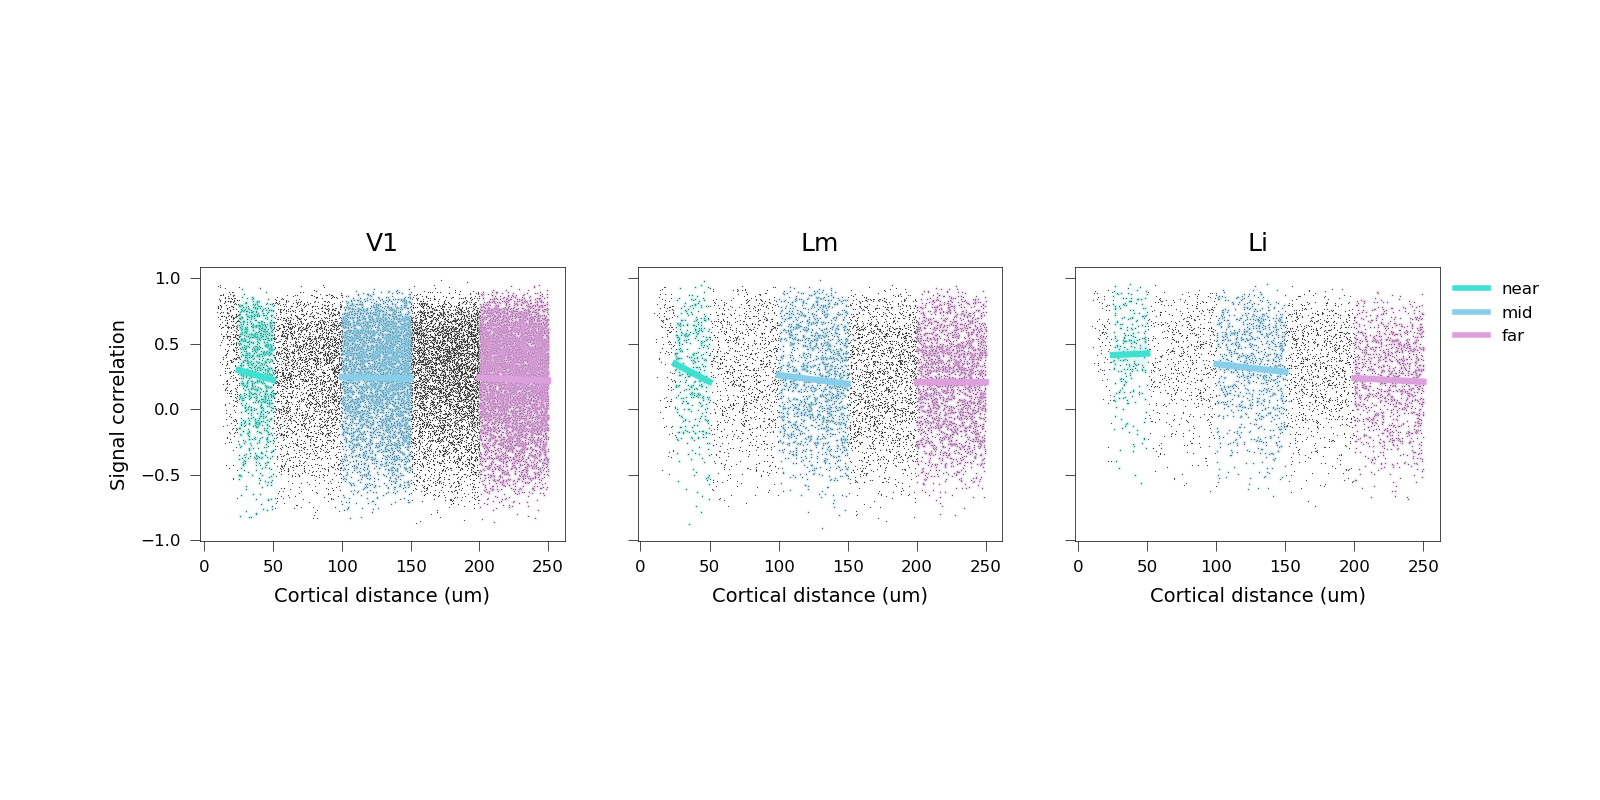

In [51]:
colors = ['turquoise', 'skyblue', 'plum']
distance_conditions = ['near', 'mid', 'far']
curr_dist_colors = dict((k, v) for k, v in zip(distance_conditions, colors))

fig, axn = pl.subplots(1, 3, sharex=False, sharey=True, figsize=(8,4))
i = 0
for vi, (va, vg) in enumerate(dist_df.groupby('visual_area')):
    va_ix = visual_areas.index(va)
    ax_ix = va_ix #*2
    ax=axn[ax_ix]
    #vg = dist_df[dist_df['visual_area']==va].copy()
    sns.scatterplot(x=dist_var, y=y_var, 
                    data=plotd[(plotd['visual_area']==va)
                         & (plotd['%s_label' % dist_var]<far_lim[-1])],
                    color='k', ax=ax, s=0.2, alpha=0.8)
    for cond, cond_df in vg.groupby('distance_cond'):
        sns.regplot(x=dist_var, y=y_var, data=cond_df,
                    color=curr_dist_colors[cond], ax=ax,
                    scatter_kws={'s':0.2, 'alpha': 0.2})
        ax.set_box_aspect(0.75)
        ax.set_title(va)
    ax.set_ylabel('Signal correlation')
    ax.set_xlabel('Cortical distance (um)')
legh = pplot.custom_legend_markers(colors=colors, labels=distance_conditions,
                                   use_patch=False, lws=2, markers='')
axn[-1].legend(handles=legh, bbox_to_anchor=(1, 1), frameon=False)

figname = 'scatter_regr_near_far_cortical_distance'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [52]:
for cond in distance_conditions:
    for va, vg in dist_df.groupby('visual_area'):
        X = vg[vg['distance_cond']==cond][dist_var].values
        y = vg[vg['distance_cond']==cond][y_var].values
        slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
        print('{}. {}: pearson-r={:.3f}, p={:.3f}'.format(cond, va, r_value, p_value)) #, r2))

near. Li: pearson-r=0.010, p=0.874
near. Lm: pearson-r=-0.108, p=0.032
near. V1: pearson-r=-0.057, p=0.070
mid. Li: pearson-r=-0.050, p=0.132
mid. Lm: pearson-r=-0.049, p=0.057
mid. V1: pearson-r=-0.008, p=0.599
far. Li: pearson-r=-0.025, p=0.390
far. Lm: pearson-r=0.001, p=0.970
far. V1: pearson-r=-0.018, p=0.158


In [292]:
xbins = sorted([i for i in dist_lut[dist_var]['bins'] if i<=far_lim[-1]])
xticks = np.arange(0, len(xbins))
xbins

[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0, 250.0]

<IPython.core.display.Javascript object>


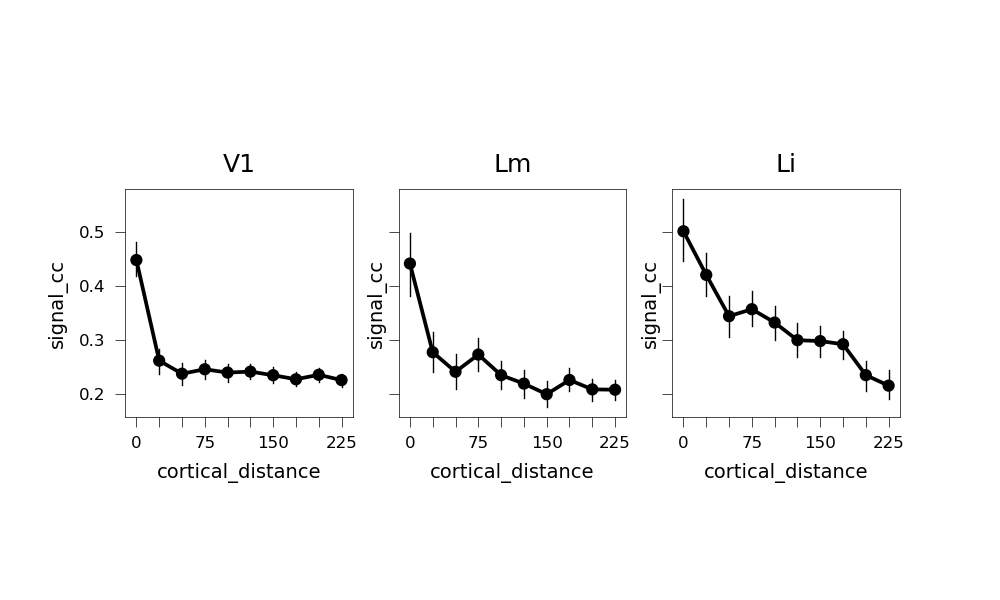

In [296]:
x_var = 'cortical_distance'
y_var = 'signal_cc'
curr_plotdf = plotd[(plotd['%s_label' % dist_var]<far_lim[-1])].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(5,3))
for vi, (va, vg) in enumerate(curr_plotdf.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    sns.pointplot(x='%s_label' % x_var, y=y_var, 
                    data=vg, ax=ax, errorbar=('ci', 95),
                    scale=0.5, errwidth=0.5, color='k')
    #x_bins = sorted(curr_plotdf['%s_label' % x_var].unique())
    xticks = ax.get_xticks()
    #ax.set_xticks(xticks-0.5)
    ax.set_xticklabels([int(xbins[i]) if i in xticks[0::3] or i==xticks[-1] \
                        else '' for i in xticks])
    ax.set_box_aspect(1)
    ax.set_xlabel(x_var)
    ax.set_title(va)

In [276]:
ax.get_xticklabels()

[Text(0, 0, '0.0'),
 Text(1, 0, '25.0'),
 Text(2, 0, '50.0'),
 Text(3, 0, '75.0'),
 Text(4, 0, '100.0'),
 Text(5, 0, '125.0'),
 Text(6, 0, '150.0'),
 Text(7, 0, '175.0'),
 Text(8, 0, '200.0'),
 Text(9, 0, '225.0')]

In [124]:
# y_var = 'signal_cc'
df_list = []

for va, vg in dist_df.groupby('visual_area'):
    true_distn=[]
    shuff_distn= []
    for i in np.arange(0, 1000):
        # Boot sample and get TRUE median
        bootd = vg.copy() #sample(frac=1, replace=True)
        med_v = bootd.sample(frac=1, replace=True).groupby(['distance_cond']).median()
        true_val = float(med_v.loc['near'][y_var]) \
                        - float(med_v.loc['far'][y_var])
        true_distn.append(true_val)
        # Shuffle labels
        shuff = vg.copy()
        shuff['distance_cond'] = shuff['distance_cond'].sample(frac=1, replace=False).values
        # Get medians for each group
        med_v_shuff = shuff.groupby(['distance_cond']).median()
        # Calculate diff
        shuff_val = float(med_v_shuff.loc['near'][y_var]) \
                        - float(med_v_shuff.loc['far'][y_var])
        shuff_distn.append(shuff_val)
    
    df_shuff = pd.DataFrame({'near_minus_far': shuff_distn})
    df_shuff['condition'] = 'shuffled'
    df_true = pd.DataFrame({'near_minus_far': true_distn})
    df_true['condition'] = 'true'
    df_ = pd.concat([df_true, df_shuff], axis=0)
    
    df_['visual_area'] = va
    #df_['true_difference'] = true_diff
    df_list.append(df_)

near_v_far = pd.concat(df_list, axis=0, ignore_index=True)

# DISTS:  Correlate tuning curves

In [190]:
create_new=True

In [191]:
avg_responses['morphlevel'].min()

-1

In [205]:
# Calculate distances
tuning_curve_data = avg_responses[avg_responses.morphlevel!=-1].copy()

if create_new:
    print("Creatnig new DISTS. Saving to:\n    %s" % dists_results_file)
    DISTS = cr.aggregate_tuning_curve_ccdist(tuning_curve_data, rfdf=rfdf, 
                                         rfpolys=rfpolys,sort_best_size=False,
                                         normalize=True,
                                         min_ncells=5, stimulus='blobs')
#     res = {'responses': avg_responses,
#            'rfdf': rfdf, 'DISTS': DISTS}
#     with open(dists_results_file, 'wb') as f:
#         pkl.dump(res, f, protocol=2)

Creatnig new DISTS. Saving to:
    /n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-none_rfs-dff-uncorr.pkl
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20191111_JC120_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20190430_JC078_fov1 NONE, skipping overlaps)
    (20190504_JC078_fov1 NONE, skipping overlaps)
    (20190506_JC080_fov1 NONE, skipping overlaps)
    (20190508_JC083_fov1 NONE, skipping overlaps)
    (20190501_JC076_fov1 NONE, skipping overlaps)
    (20190507_JC083_fov1 NONE, skipping overlaps)
[]


In [80]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr'

In [ ]:
print(dists_results_file)

# MERGE DISTS and CORRS

In [194]:
CORRS.head()

cell_1  cell_2  signal_cc neuron_pair  noise_cc  cortical_distance  \
0      76      80   0.616004       76_80  0.347473          50.195743   
1      76      81   0.580529       76_81  0.300683          73.768600   
2      76     119   0.603707      76_119  0.352520          82.268232   
3      76     135   0.464694      76_135  0.208156         189.151666   
4      76     136   0.167024      76_136  0.100257         163.134469   

  visual_area              datakey experiment  n_cells  
0          Li  20190422_JC076_fov1      blobs       29  
1          Li  20190422_JC076_fov1      blobs       29  
2          Li  20190422_JC076_fov1      blobs       29  
3          Li  20190422_JC076_fov1      blobs       29  
4          Li  20190422_JC076_fov1      blobs       29

In [206]:
DISTS.head()

xcorr_morph  pearsons_morph  cosim_morph  cell_1  cell_2 neuron_pair  \
0     4.063408        0.698949     0.959023    76.0    80.0       76_80   
1     3.200770       -0.122446     0.890764    76.0    81.0       76_81   
2     3.685720        0.437926     0.942992    76.0   119.0      76_119   
3     2.807402       -0.013169     0.832709    76.0   135.0      76_135   
4     2.914360       -0.263580     0.870905    76.0   136.0      76_136   

   xcorr_size  pearsons_size  cosim_size  max_response  ...  \
0    1.513496       0.777778    0.863933      0.600692  ...   
1    0.893625      -0.449815    0.579897      0.630790  ...   
2    1.411922       0.674091    0.870050      0.313761  ...   
3    1.451351       0.347309    0.788222      0.668692  ...   
4    0.858750      -0.331636    0.537378      0.674573  ...   

   rf_angle_diff_abs  std_x  std_y  aspect_ratio  area_overlap  perc_overlap  \
0                NaN    NaN    NaN           NaN           NaN           NaN   
1                NaN    NaN    NaN           NaN           NaN           NaN   
2                NaN    NaN    NaN           NaN           NaN           NaN   
3                NaN    NaN    NaN           NaN           NaN           NaN   
4                NaN    NaN    NaN           NaN           NaN           NaN   

   overlap_index  visual_area              datakey  n_cells  
0            NaN           Li  20190422_JC076_fov1       29  
1            NaN           Li  20190422_JC076_fov1       29  
2            NaN           Li  20190422_JC076_fov1       29  
3            NaN           Li  20190422_JC076_fov1       29  
4            NaN           Li  20190422_JC076_fov1       29  

[5 rows x 25 columns]

In [207]:
DISTS = DISTS.rename(columns={'n_cells':'n_cells_fit'}).reset_index(drop=True)
CORRS = CORRS.rename(columns={'n_cells':'n_cells_responsive'}).reset_index(drop=True)
incl_cc_cols = ['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
               'visual_area', 'datakey', 'n_cells_responsive']

In [208]:
ccdist = pd.merge(CORRS[incl_cc_cols], DISTS,
            on=['visual_area', 'datakey', 'neuron_pair', 'cell_1', 'cell_2'], 
            how='outer', suffixes=('_fit', '_responsive'))
ccdist.shape, DISTS.shape, CORRS.shape

((138186, 28), (138186, 25), (111327, 10))

#### Check merge

In [209]:
check_pairs=[]
for (va, dk), g in DISTS.groupby(['visual_area', 'datakey']):
    curr_pairs = g['neuron_pair'].values
    cc = CORRS[(CORRS.visual_area==va) & (CORRS.datakey==dk)]
    not_in_cc = [k for k in curr_pairs if (k not in cc['neuron_pair'].values)
                and (k[::-1] not in cc['neuron_pair'].values)]
    if len(not_in_cc)>0:
        check_pairs.append(g[g['neuron_pair'].isin(not_in_cc)])
if len(check_pairs)>0:
    checkdf = pd.concat(check_pairs, axis=0, ignore_index=True)
else:
    print("Correct matches")

# Heatmaps: cortical vs. RF distance

In [793]:
# Split distances into X um bins
x_var = 'cortical_distance'
y_var = 'overlap_index'
hue_var = 'pearsons_size'
# -----------------------------
ctx_maxdist = 500 #500
rf_maxdist=50
if hue_var == 'signal_cc':
    df, dist_lut = cr.get_bins_and_cut(ccdist[(ccdist.cortical_distance<=ctx_maxdist)
                                        & (ccdist.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
else:
    df, dist_lut = cr.get_bins_and_cut(DISTS[(DISTS.cortical_distance<=ctx_maxdist)
                                        & (DISTS.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
    
print(df.groupby([x_var, y_var])[hue_var].mean().min())
print(df.groupby([x_var, y_var])[hue_var].mean().max())

-0.9965961555009633
0.999857949592178


<IPython.core.display.Javascript object>


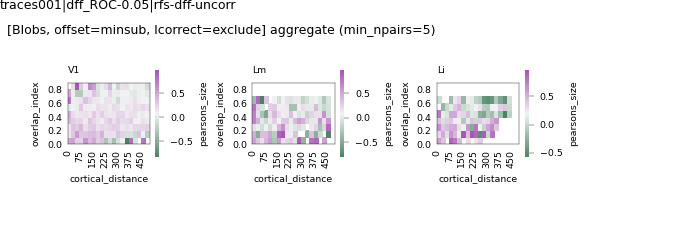

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_aggrFOV_overlap_index_v_cortical_distance_hue-pearsons_size


In [794]:
# x_var = 'cortical_distance'
# y_var = 'overlap_index'
# hue_var = 'pearsons_morph'
# -----------------------------
min_npairs=5
x_bins = dist_lut[x_var]['bins']
y_bins = dist_lut[y_var]['bins']
hue_min, hue_max = None, None #@(-1, 1)
#hue_min, hue_max =  (-0.2, 0.5) #if hue_var=='pearsons_morph' else (-0.6, 0.6)
#hue_min, hue_max =  (-0.3, 0.8)

cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

fig, axn = pl.subplots(1, 3, figsize=(6, 2), dpi=150, sharex=True, sharey=False)
# cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=min_npairs][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=min_npairs][y_var_name].unique()
    df0 = vg[(vg[x_var_name].isin(valid_x)) & (vg[y_var_name].isin(valid_y))]

    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=True, cbar_kws={'shrink':0.5})
#                                       cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(va, loc='left', fontsize=6)
    yticks = np.arange(0, len(y_bins))
    curr_ylim = df0.dropna()[y_var_name].max()
    ax.set_ylim([0, list(y_bins).index(curr_ylim)])
    ax.set_ylabel(y_var)
    ax.set_xlabel(x_var)
    # ax.invert_yaxis()
fig.text(0.01, 0.85, '[Blobs, offset=%s, lcorrect=%s] aggregate (min_npairs=%i)' 
         % (offset_type, lcorrection, min_npairs), fontsize=8)
pl.subplots_adjust(wspace=0.8, right=0.8, left=0.1)

pplot.label_figure(fig, data_id)
figname = 'heatmaps_aggrFOV_%s_v_%s_hue-%s' % (y_var, x_var, hue_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


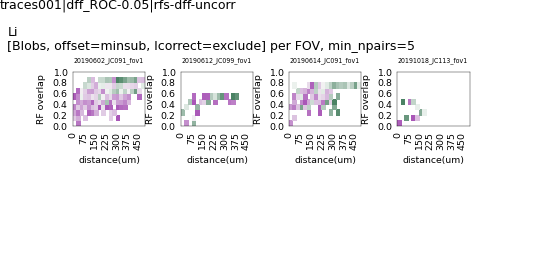

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_Li_overlap_index_v_cortical_distance_hue-pearsons_size


<IPython.core.display.Javascript object>


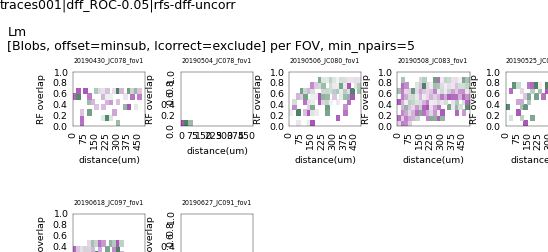

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_Lm_overlap_index_v_cortical_distance_hue-pearsons_size


<IPython.core.display.Javascript object>


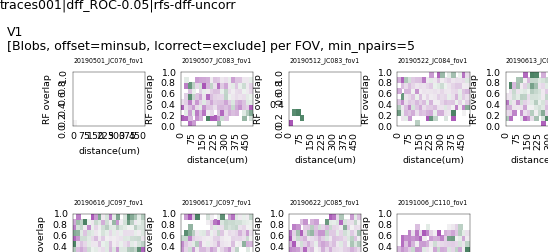

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_V1_overlap_index_v_cortical_distance_hue-pearsons_size


In [795]:
nr=2
nc=5

#hue_min, hue_max = (-.6, 0.6) #if hue_var=='pearsons_morph' else (-0.6, 0.6)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)

for va, vg in df.groupby('visual_area'):
    fig, axn = pl.subplots(nr, nc, figsize=(6.5,3), dpi=150, 
                           sharex=False, sharey=False)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.3])
    grped_means = vg.groupby(['%s_label' % x_var, '%s_label' % y_var]).mean()
    i=0
    for ai, (ax, (dk, df_)) in enumerate(zip(axn.flat, vg.groupby('datakey'))):
        ax=cr.heatmap_tuning_v_distance(df_, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=ai==0, #lw=0.5,
                                      cbar_ax=cbar_ax if ai==0 else None)
        ax.set_title(dk, loc='left', fontsize=4)
        ax.set_xlabel('distance(um)')
        ax.set_ylabel('RF overlap')
        i+=1
    for ai in np.arange(i, nr*nc):
        axn.flat[ai].axis('off')
    pl.subplots_adjust(wspace=0.5, right=0.79, left=0.1)
    fig.text(0.01, 0.85, '%s\n[Blobs, offset=%s, lcorrect=%s] per FOV, min_npairs=%i' 
         % (va, offset_type, lcorrection, min_npairs), fontsize=8)

    pplot.label_figure(fig, data_id)
    figname = 'heatmaps_byFOV_%s_%s_v_%s_hue-%s' % (va, y_var, x_var, hue_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [69]:
df0.groupby([x_var, y_var])['neuron_pair'].count()

cortical_distance  overlap_index
8.901078           0.452692         1
9.793585           0.389434         1
9.973373           0.119427         1
                   0.245038         1
10.285077          0.409872         1
                                   ..
499.843022         0.713651         1
499.894386         0.433298         1
                   0.764703         1
499.896163         0.700457         1
499.985442         0.901521         1
Name: neuron_pair, Length: 13879, dtype: int64

In [80]:
cnts.fillna(value=0)

cortical_distance_label  overlap_index_label  neuron_pair
0                        0.0                 0.10            5
1                        0.0                 0.15           10
2                        0.0                 0.20           18
3                        0.0                 0.25           20
4                        0.0                 0.30           22
..                       ...                  ...          ...
353                    475.0                 0.75           84
354                    475.0                 0.80           59
355                    475.0                 0.85           41
356                    475.0                 0.90           35
357                    475.0                 0.95           26

[358 rows x 3 columns]

<IPython.core.display.Javascript object>


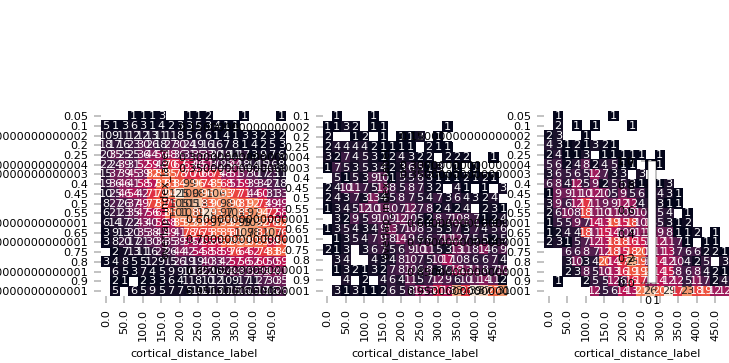

In [86]:
fig, axn = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharex=True, sharey=False)
cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    cnt_table = cnts.fillna(value=0).pivot(y_var_name, x_var_name, 'neuron_pair')
    sns.heatmap(cnt_table, annot=True, fmt=".0f", ax=ax,
               annot_kws={'fontsize': 6}, cbar=False)
    ax.set_box_aspect(1)
    